In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(crayon)
    library(tidyverse)
}))

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    prj_path = "/home/vsevim/prj/1012-ckd/S1/"
    data_subdir = "/analysis/primary/cellranger/Screen1_66guides_L1/outs/"
    souporcell_clusters_path = "/home/vsevim/prj/1012-ckd/S1/analysis/primary/souporcell/Lib_1/clusters.tsv"
    seurat_obj_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/"
    seurat_obj_fname = "Screen1_66guides_Lib_1.h5seurat"

    library_name = "Lib_1"
    save_seurat_h5 = "NO"

    # prj_name    = "Screen2_101vecs"
    # prj_path    = "/home/vsevim/prj/1012-ckd/S2/"
    # data_subdir = "/analysis/primary/cellranger/Screen2_101vecs_1/outs/"
    # souporcell_clusters_path = "/home/vsevim/prj/1012-ckd/S2/analysis/primary/souporcell/Lib_1/clusters.tsv"
    # seurat_obj_path  = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/Lib_1/seurat_objects/"
    # seurat_obj_fname = "Screen2_101vecs_Lib_1.h5seurat"

    # library_name = "Lib_1"
    # save_seurat_h5 = "NO"
}

In [4]:
data_path <- paste0(prj_path, data_subdir)
mx_path   <- paste0(data_path, "/filtered_feature_bc_matrix/")
h5_path   <- paste0(data_path, "/filtered_feature_bc_matrix.h5")
umi_thresholds_path <- paste0(data_path, "/crispr_analysis/protospacer_umi_thresholds.csv")
ps_calls_path <- paste0(data_path, "/crispr_analysis/protospacer_calls_per_cell.csv")
stats_out_path <- paste0(prj_path, "/analysis/primary/stats/")
save_h5_file <- paste0(seurat_obj_path, seurat_obj_fname)

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

In [6]:
data_path

[1] "/home/vsevim/prj/1012-ckd/S1//analysis/primary/cellranger/Screen1_66guides_L1/outs/"

In [7]:
if(!file.exists(souporcell_clusters_path)){    
    cat(souporcell_clusters_path, "DOES NOT EXIST!")
    stopifnot(FALSE)
}

### Load cell-cycle data

In [8]:
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes


### Import demux counts from Cellranger

In [9]:
df_thresholds = read.csv(umi_thresholds_path)
df_ps_calls   = read.csv(ps_calls_path)

### Load 10x data

In [10]:
inputdata   <- Read10X_h5(h5_path)

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [11]:
# extract RNA and sgRNA data
rna_counts   <- inputdata$`Gene Expression`
sgrna_counts <- inputdata$`CRISPR Guide Capture`

In [12]:
dim(rna_counts)
dim(sgrna_counts)

[1] 36602  9183

[1]  132 9183

In [13]:
n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
all_protospacer_ids = colnames(sgrna_counts)
n_genes = sum(rowSums(rna_counts) > 0)
cat(blue(prj_name, library_name), "\n")
cat(blue("#cells recovered:", n_cells_from_cellranger), "\n")
cat(blue("#genes recovered:", n_genes), "\n")
cat(blue("#protospacers in assay:", n_protospacers), "\n")

stats[["Screen"]]                = prj_name 
stats[["Library"]]               = library_name
stats[["Cells_recovered"]]       = n_cells_from_cellranger
stats[["Genes_recovered"]]       = n_genes
stats[["Protospacers_in_assay"]] = n_protospacers

Screen1_66guides Lib_1 
#cells recovered: 9183 
#genes recovered: 31871 
#protospacers in assay: 132 


# Visualize protospacer counts

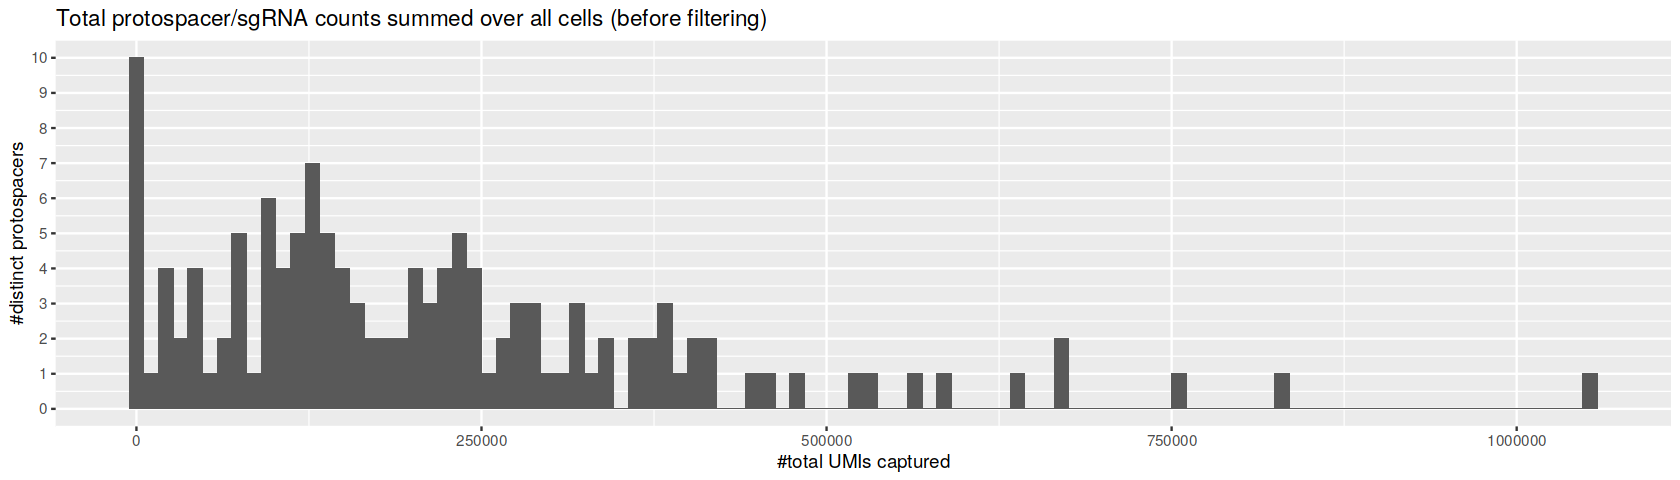

In [14]:
df_guide_counts = data.frame(total_guide_count=rowSums(sgrna_counts))
row.names(df_guide_counts) <- row.names(sgrna_counts)

options(repr.plot.width=14, repr.plot.height=4)
ggplot(df_guide_counts, aes(x = total_guide_count)) +
    geom_histogram(bins=100) +
    labs(title = "Total protospacer/sgRNA counts summed over all cells (before filtering)", x = "#total UMIs captured") +
    labs(y = "#distinct protospacers") +
    scale_y_continuous(breaks=seq(0,10, by=1))


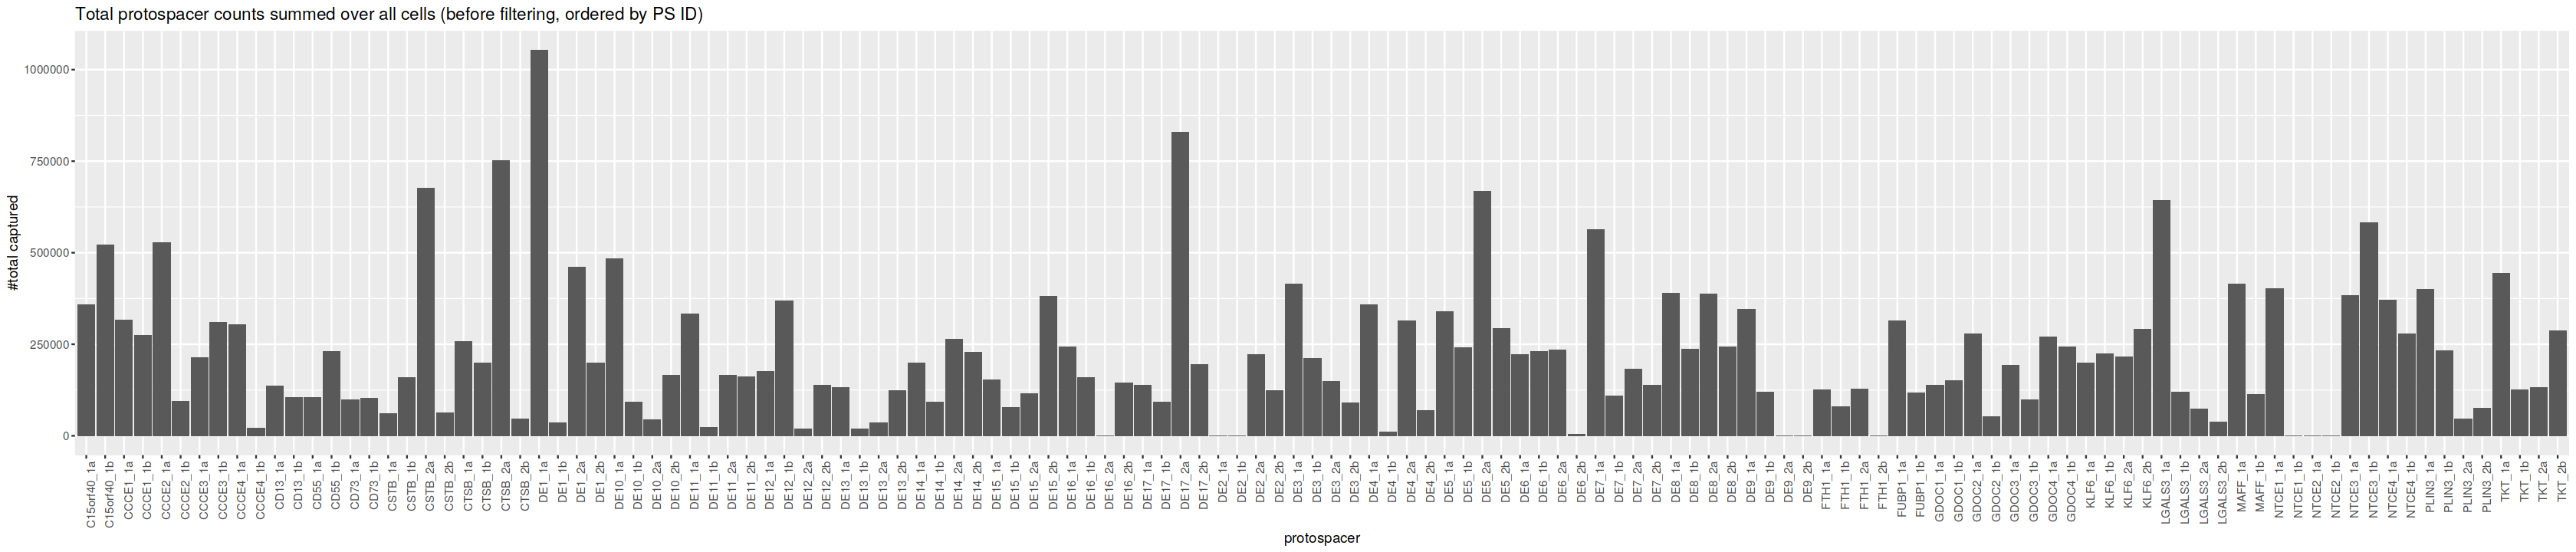

In [15]:
df_guide_counts_ordered <- df_guide_counts[order(df_guide_counts$total_guide_count),,drop=FALSE]
df_guide_counts_ordered$protospacer  <- rownames(df_guide_counts_ordered)

options(repr.plot.width=28, repr.plot.height=6)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by PS ID)", x = "protospacer") +
    labs(y = "#total captured") 

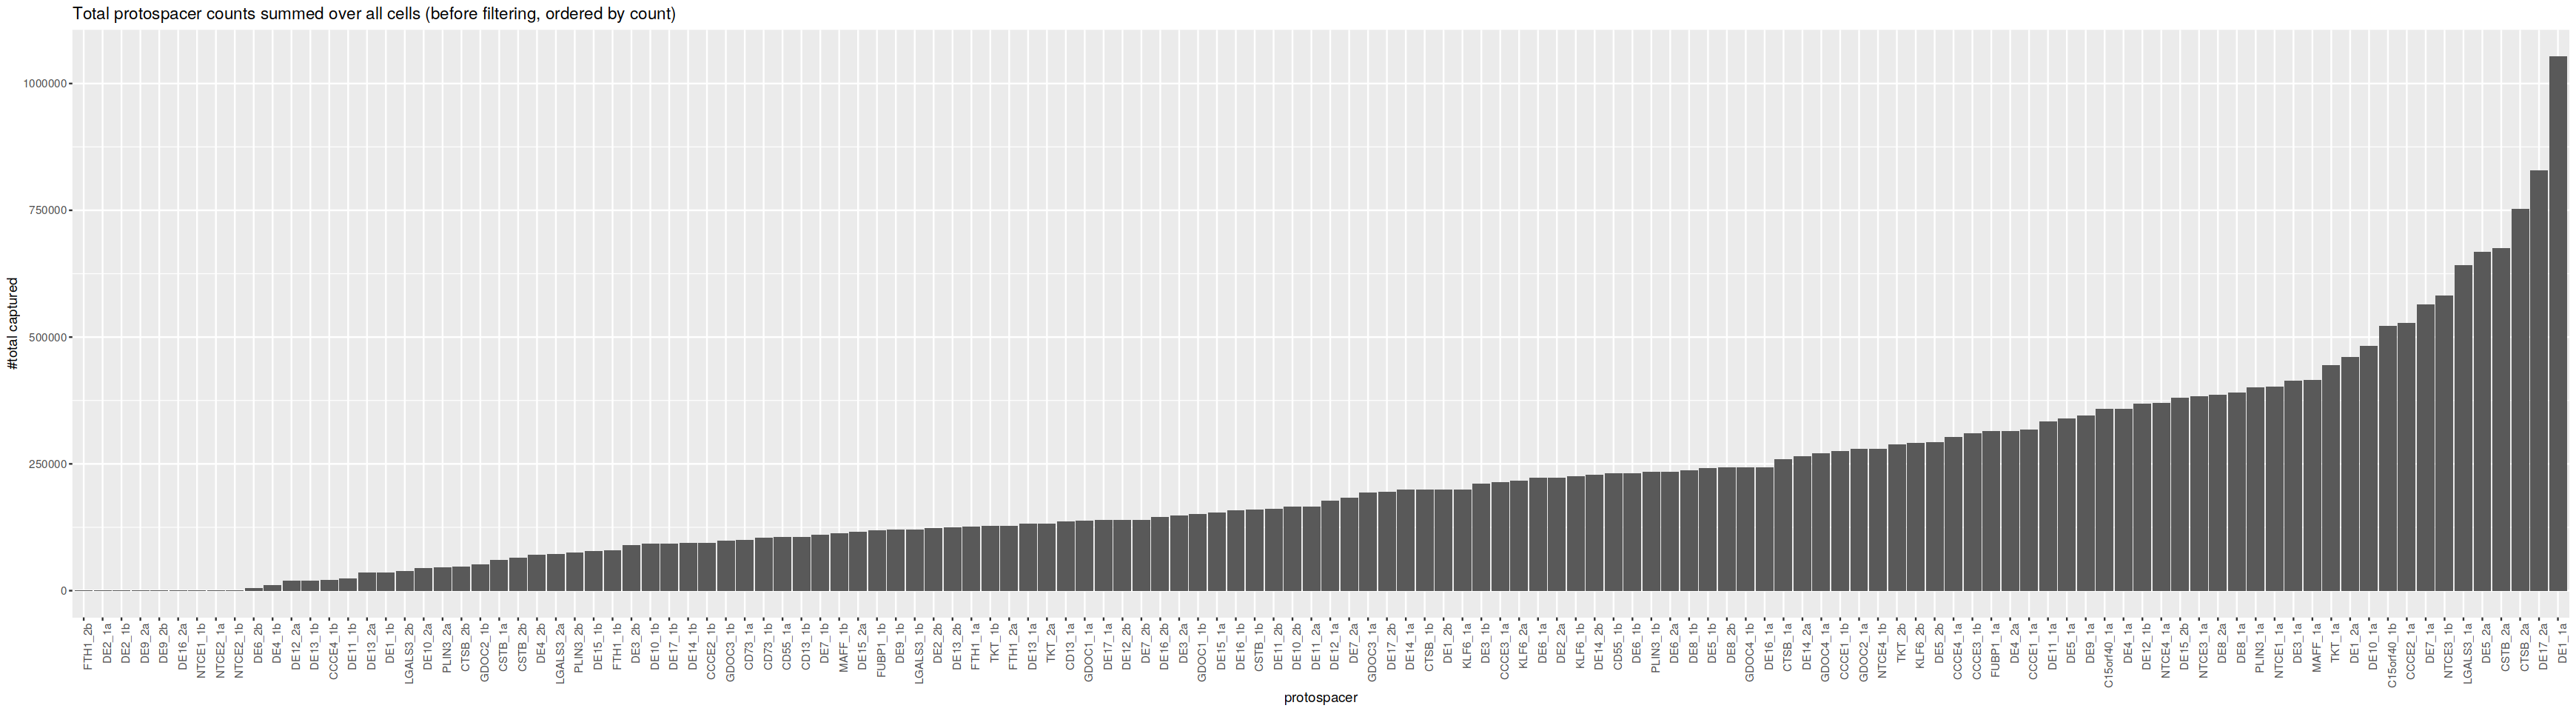

In [16]:
df_guide_counts_ordered$protospacer <- factor(df_guide_counts_ordered$protospacer, levels = df_guide_counts_ordered$protospacer)

options(repr.plot.width=29, repr.plot.height=8)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by count)", x = "protospacer") +
    labs(y = "#total captured") 

In [17]:
head(df_guide_counts_ordered,10)

total_guide_count protospacer
FTH1_2b     0              FTH1_2b    
DE2_1a      0              DE2_1a     
DE2_1b      0              DE2_1b     
DE9_2a      0              DE9_2a     
DE9_2b      0              DE9_2b     
DE16_2a     0              DE16_2a    
NTCE1_1b    0              NTCE1_1b   
NTCE2_1a    0              NTCE2_1a   
NTCE2_1b    0              NTCE2_1b   
DE6_2b   4074              DE6_2b

### Create Seurat object

In [18]:
seurat_unfiltered <- CreateSeuratObject(counts = rna_counts, project = prj_name)
sgrna_assay       <- CreateAssayObject(counts = sgrna_counts)
seurat_unfiltered[["sgRNA"]] <- sgrna_assay
seurat_unfiltered$library = library_name

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


### Get mitochondrial content

In [19]:
seurat_unfiltered[["percent.mt"]] <-
    PercentageFeatureSet(seurat_unfiltered, pattern = "^MT-")

In [20]:
DefaultAssay(seurat_unfiltered) <- "RNA"

## QC

### Get RNA counts per cell

In [21]:
counts_per_cell <- Matrix::colSums(rna_counts)
cat("counts per cell: ", counts_per_cell[1:20], "\n") ## counts for first 5 cells

counts per cell:  25185 126446 43958 73018 63652 34135 58986 39723 41606 34297 85992 24157 53029 60204 44130 90248 42316 9404 53301 60509 


In [22]:
counts_per_gene <- Matrix::rowSums(rna_counts)
cat("counts per gene: ", counts_per_gene[1:20], "\n")  

counts per gene:  3 0 4 156 9 0 224 3 0 2 0 1 0 3 2695 4 3176 149 463 115 


In [23]:
genes_per_cell  <- Matrix::colSums(rna_counts > 0)       # count gene only if it has non-zero reads mapped.
guides_per_cell <- Matrix::colSums(sgrna_counts > 0)     # count gene only if it has non-zero reads mapped.

cat("counts for non-zero genes: ", genes_per_cell[1:5], "\n")  # counts for first 5 genes
cat("counts for non-zero guides:", guides_per_cell[1:5], "\n")  # counts for first 5 genes

counts for non-zero genes:  5887 11084 7411 9094 8614 
counts for non-zero guides: 19 28 31 22 20 


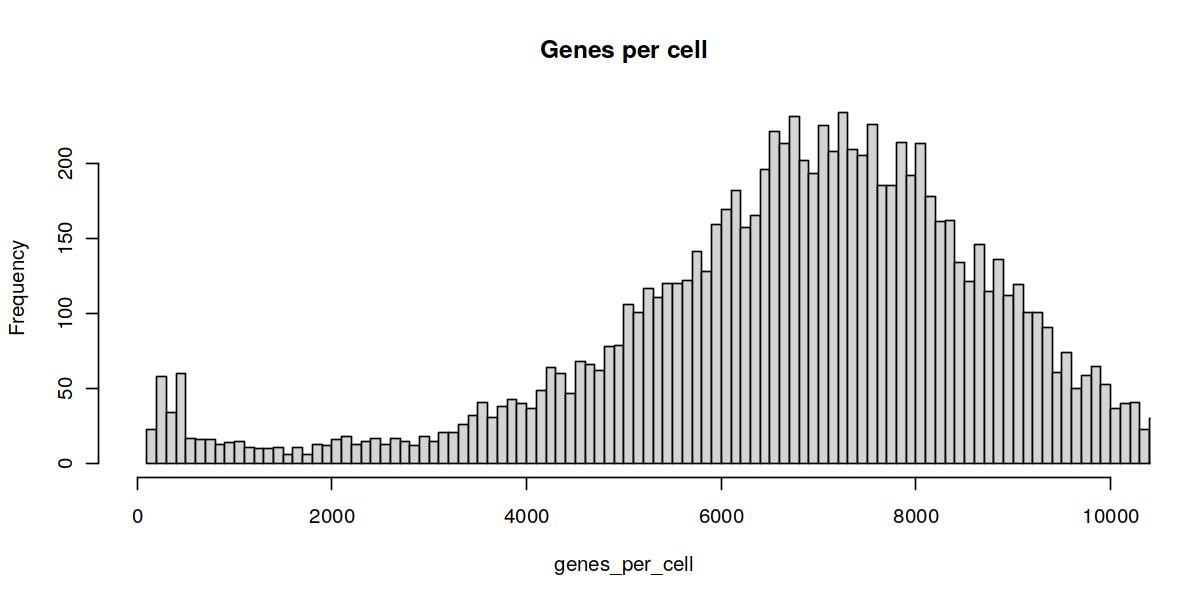

In [24]:
options(repr.plot.width=10, repr.plot.height=5)
#plot_log <- hist(log10(genes_per_cell), main="Genes per cell", breaks=100)
plot_lin <- hist(genes_per_cell, main="Genes per cell", breaks=100, xlim=c(1,10000))
#plot_guide_counts <- hist(guides_per_cell, main="Distinct protospacers per cell", breaks=100, xlim=c(1,100))

### --

### Plot RNA counts per cell 

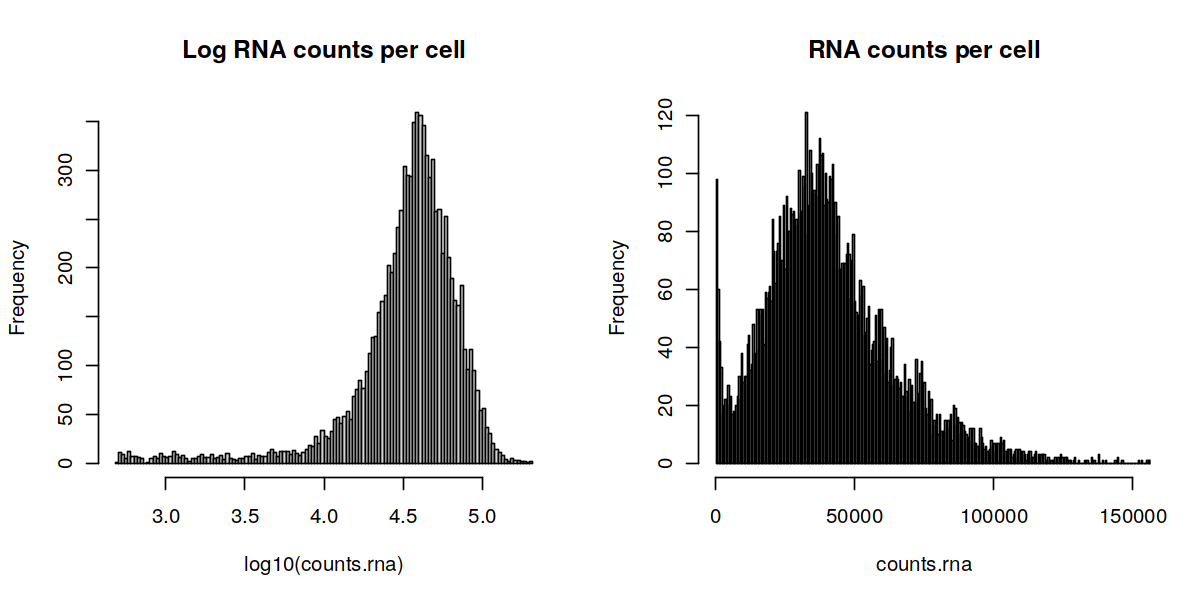

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.rna <- seurat_unfiltered@meta.data$nCount_RNA
plot_log    <- hist(log10(counts.rna), main="Log RNA counts per cell", breaks=100)
plot_lin    <- hist(counts.rna, main="RNA counts per cell", breaks=500, xlim=c(1,150000))

### Plot sgRNA counts per cell 

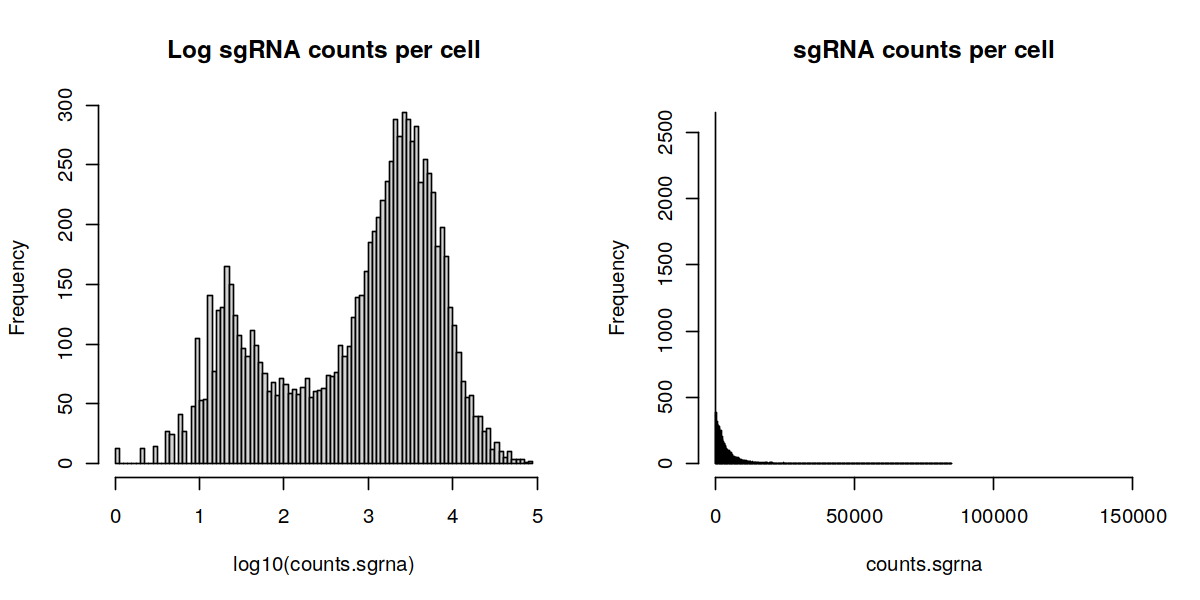

In [26]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.sgrna <- seurat_unfiltered@meta.data$nCount_sgRNA
plot_log    <- hist(log10(counts.sgrna), main="Log sgRNA counts per cell", breaks=100)
plot_lin    <- hist(counts.sgrna, main="sgRNA counts per cell", breaks=500, xlim=c(1,150000))

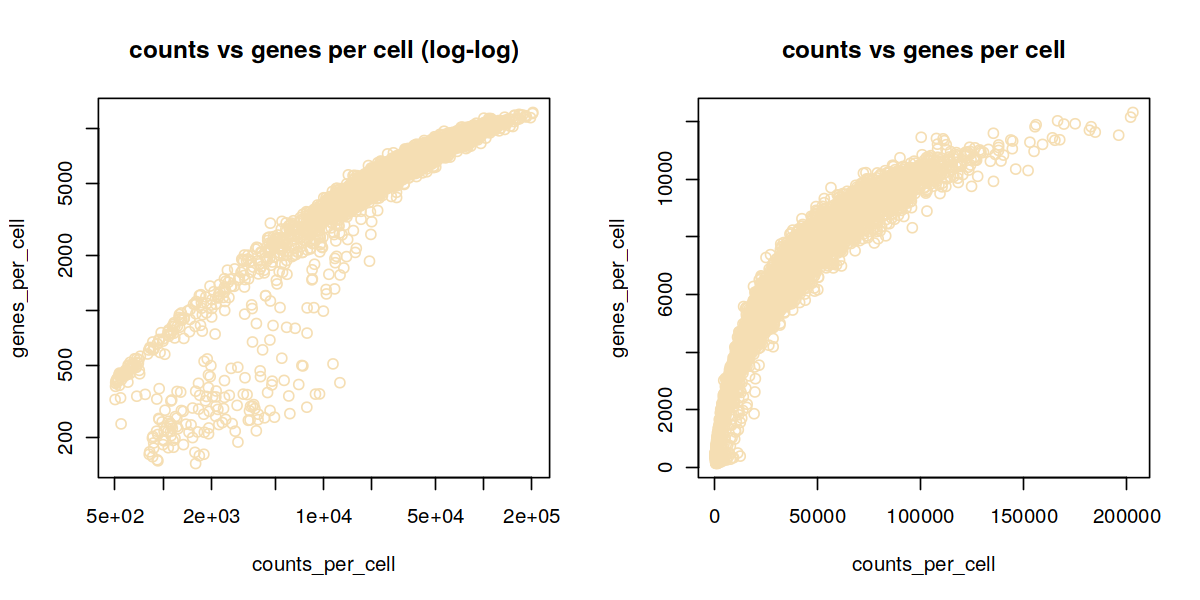

In [27]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell (log-log)')
plot(counts_per_cell, genes_per_cell, col='wheat')
title('counts vs genes per cell')

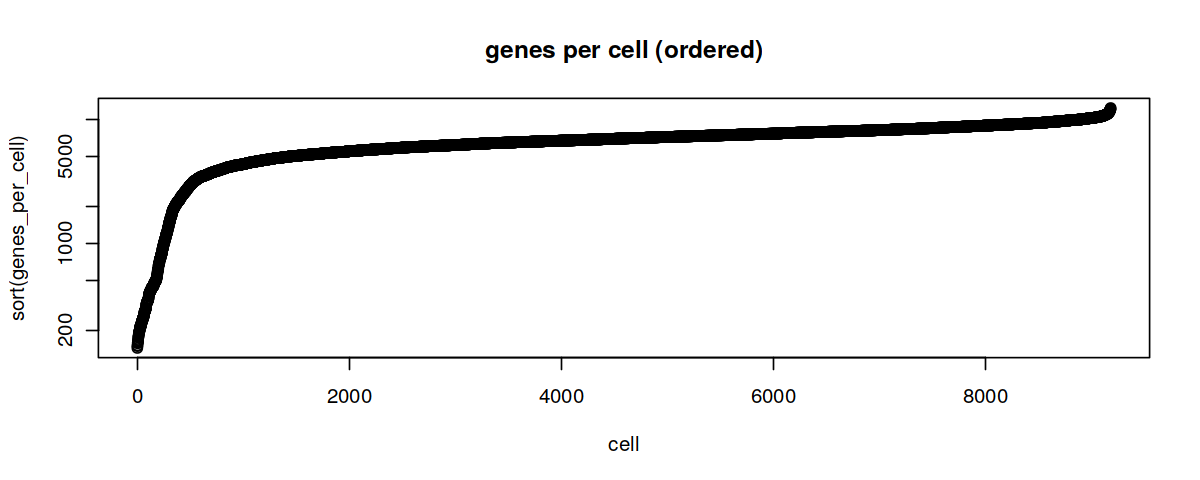

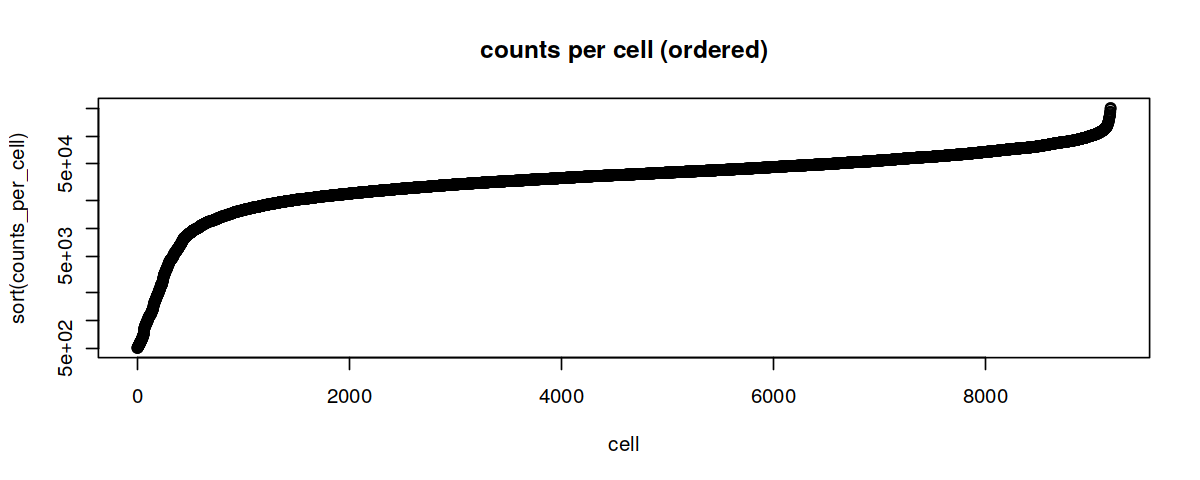

In [28]:
options(repr.plot.width=10, repr.plot.height=4)
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')
plot(sort(counts_per_cell), xlab='cell', log='y', main='counts per cell (ordered)')

In [29]:
#FeatureScatter(object = seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "nCount_ATAC", log)

### QC using houskeeping genes

In [30]:
# Load the the list of house keeping genes
hkgenes <- read.table("/home/vsevim/prj/tf/tf1/data/QC/housekeeping.txt", skip = 2)
hkgenes <- as.vector(hkgenes$V1)

In [31]:
# remove hkgenes that were not found
hkgenes.found <- which(toupper(rownames(seurat_unfiltered@assays$RNA@data)) %in% hkgenes)

In [32]:
num_hk_genes = length(hkgenes.found)
num_hk_genes

[1] 95

In [33]:
n.expressed.hkgenes <- Matrix::colSums(seurat_unfiltered@assays$RNA@data[hkgenes.found, ] > 0)

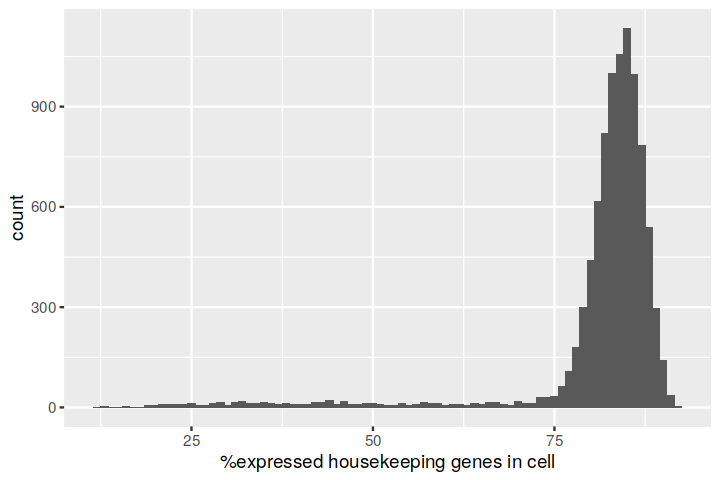

In [34]:
options(repr.plot.width=6, repr.plot.height=4)
df.expressed.hk <- data.frame(100*n.expressed.hkgenes/num_hk_genes)
ggplot(df.expressed.hk, aes(n.expressed.hkgenes)) + geom_histogram(binwidth=1) + labs(x="%expressed housekeeping genes in cell")

### QC by mitochondrial genes

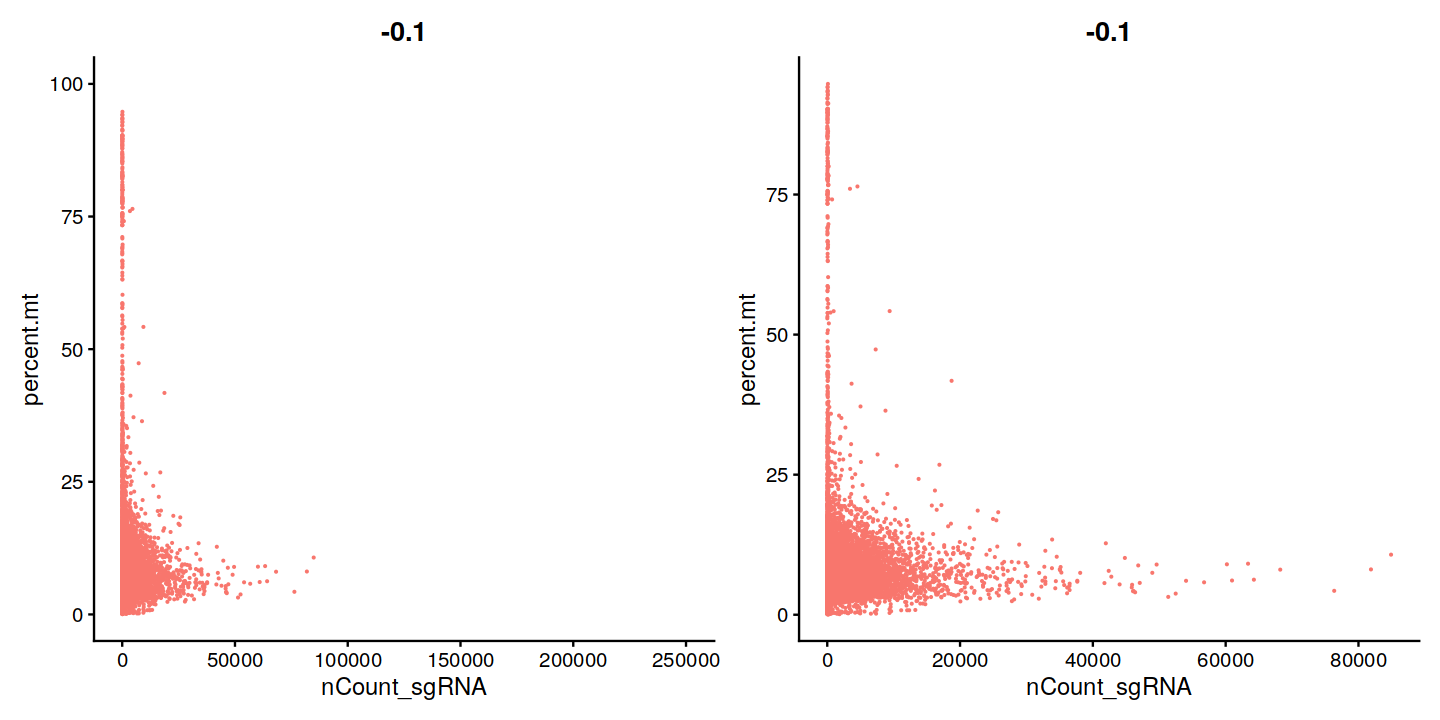

In [35]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_sgRNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend() | plot1 + NoLegend()

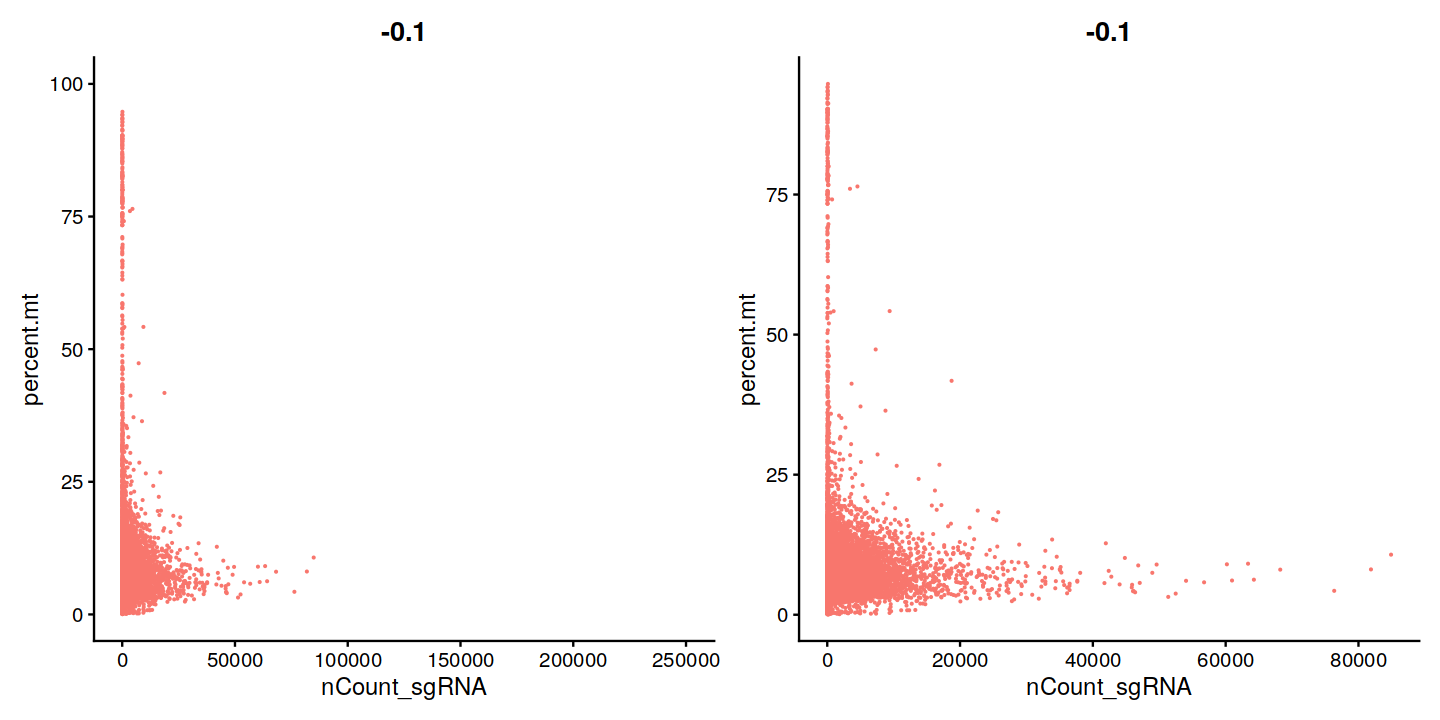

In [36]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_sgRNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend() | plot1 + NoLegend()

## Filtering

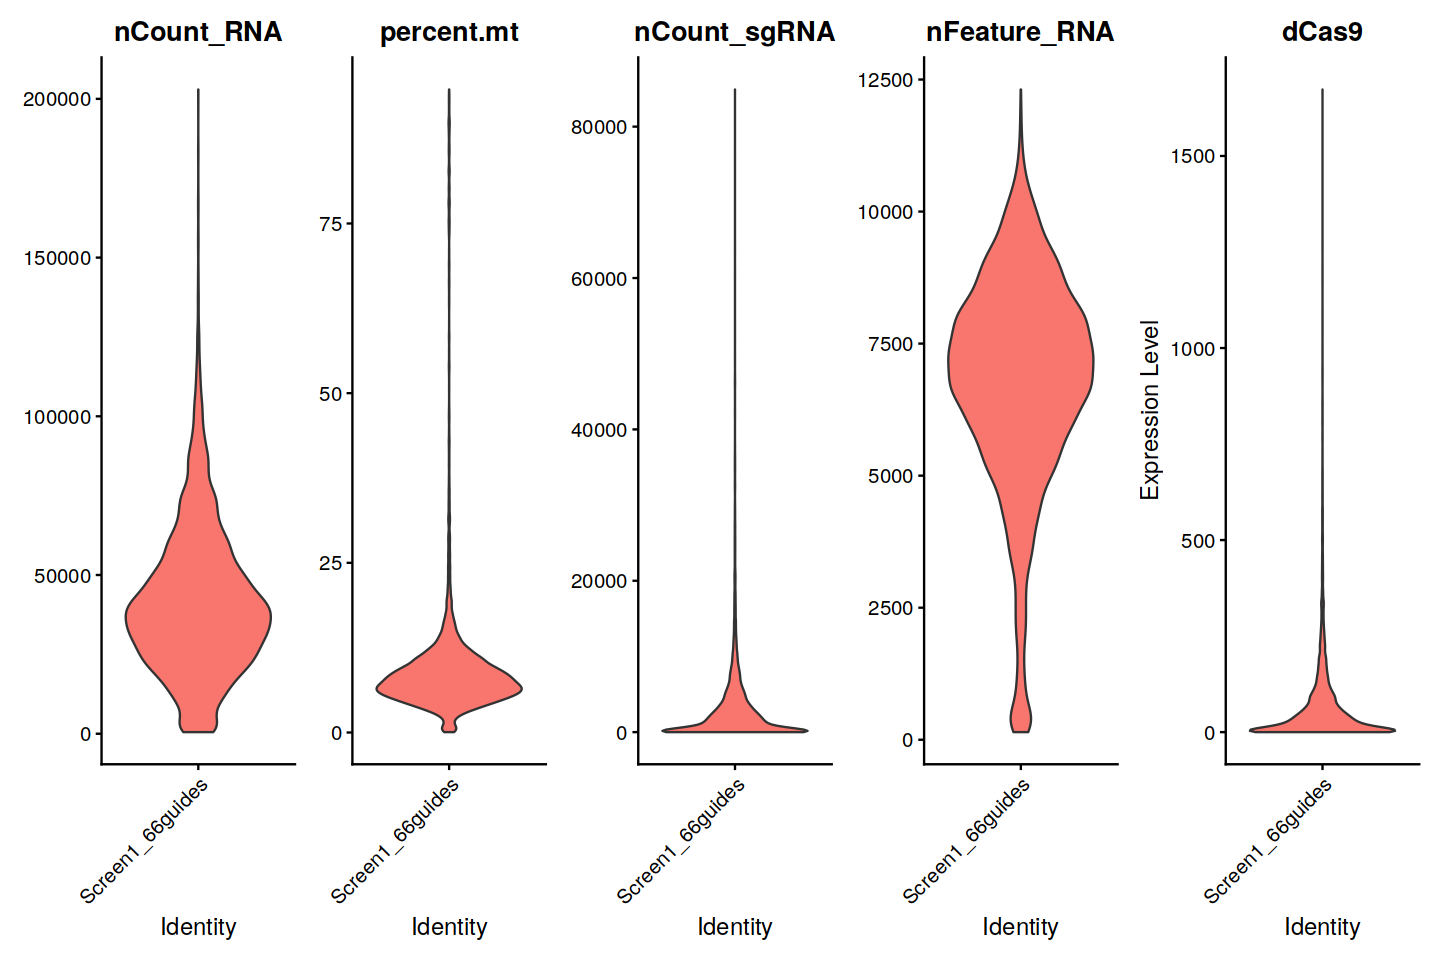

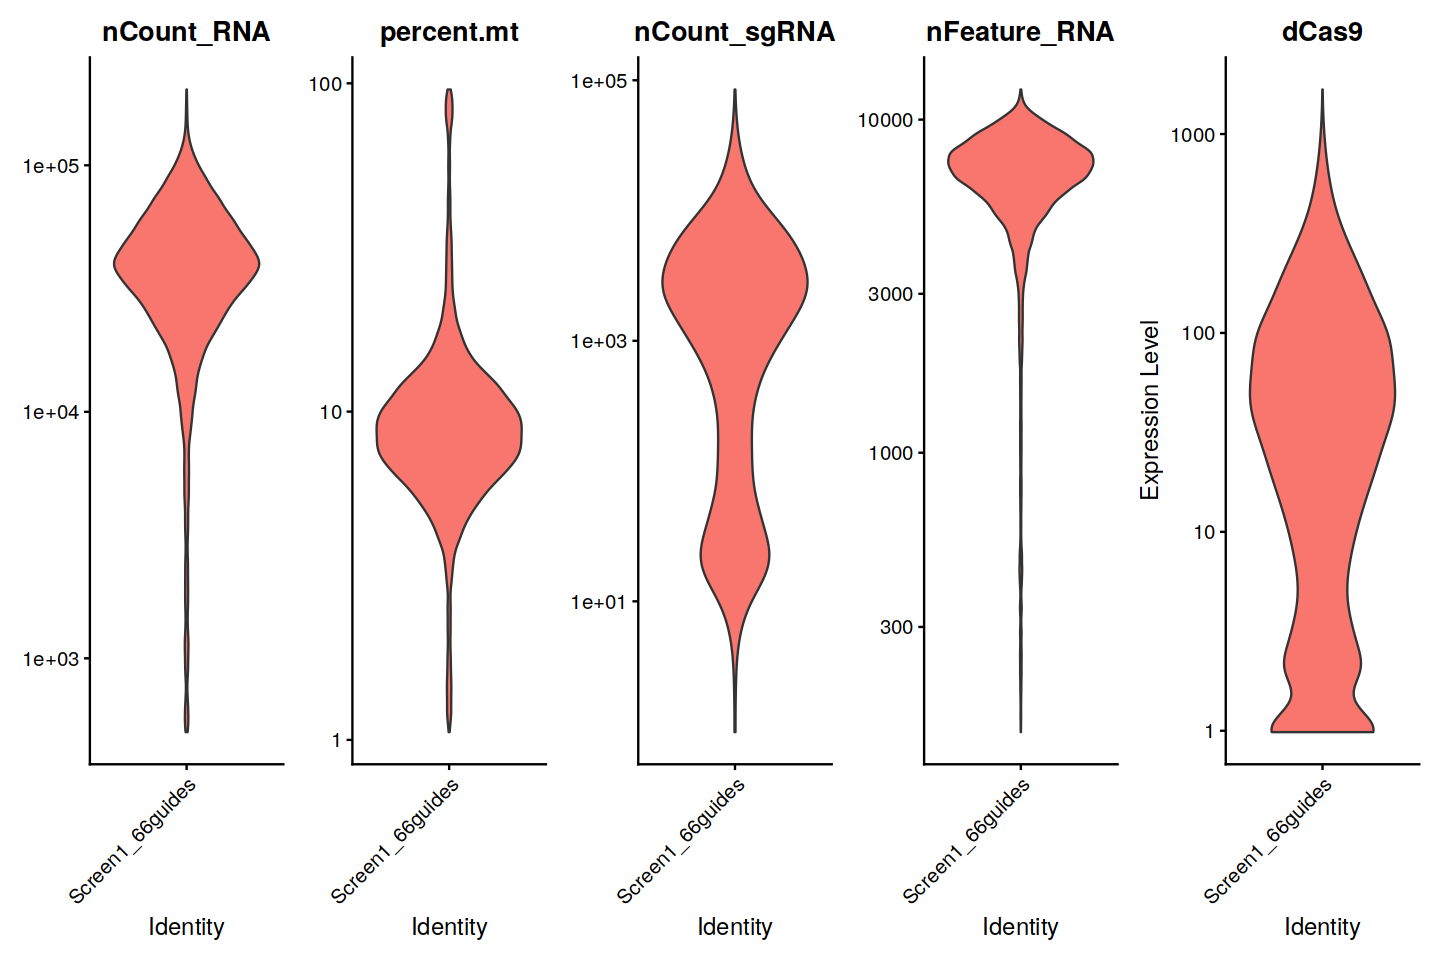

In [37]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat_unfiltered,
  features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"),
  ncol = 5,
  log=FALSE,
  pt.size = 0
)

VlnPlot(
  object = seurat_unfiltered,
  features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"),
  ncol = 5,
  log=TRUE,
  pt.size = 0
)

### Filter out low quality cells

In [38]:
mads = 3
min_mito_perc_threshold = 3
min_genes_threshold = 2000

desired_max_mito <- median(seurat_unfiltered$percent.mt) + mads*mad(seurat_unfiltered$percent.mt)
desired_min_mito <- median(seurat_unfiltered$percent.mt) - mads*mad(seurat_unfiltered$percent.mt)
desired_min_mito <- max(desired_min_mito, min_mito_perc_threshold)

desired_max_rna <- median(seurat_unfiltered$nCount_RNA) + mads*mad(seurat_unfiltered$nCount_RNA)
desired_min_rna <- median(seurat_unfiltered$nCount_RNA) - mads*mad(seurat_unfiltered$nCount_RNA)

desired_max_genes <- median(seurat_unfiltered$nFeature_RNA) + mads*mad(seurat_unfiltered$nFeature_RNA)
desired_min_genes <- median(seurat_unfiltered$nFeature_RNA) - mads*mad(seurat_unfiltered$nFeature_RNA)
desired_min_genes <- max(desired_min_genes, min_genes_threshold)

In [39]:
stats[["Max_mito_perc_threshold"]] = desired_max_mito
stats[["Min_mito_perc_threshold"]] = desired_min_mito

stats[["Max_n_RNA_threshold"]] = desired_max_rna
stats[["Min_n_RNA_threshold"]] = desired_min_rna

stats[["Max_n_genes_threshold"]] = desired_max_genes
stats[["Min_n_genes_threshold"]] = desired_min_genes

In [40]:
for(stat in names(stats)){
    cat(blue(stat), ":", stats[[stat]], "\n")
}

Screen : Screen1_66guides 
Library : Lib_1 
Cells_recovered : 9183 
Genes_recovered : 31871 
Protospacers_in_assay : 132 
Max_mito_perc_threshold : 17 
Min_mito_perc_threshold : 3 
Max_n_RNA_threshold : 98499 
Min_n_RNA_threshold : -22205 
Max_n_genes_threshold : 12196 
Min_n_genes_threshold : 2000 


In [103]:
seurat <- subset(
  x = seurat_unfiltered,
  subset = 
    nCount_RNA < desired_max_rna &
    nCount_RNA > desired_min_rna &
    percent.mt < desired_max_mito & 
    percent.mt > desired_min_mito &
    nFeature_RNA < desired_max_genes &
    nFeature_RNA > desired_min_genes 
)

In [104]:
stats[["Cells_after_QC_filtering"]] <- length(Cells(seurat))
stats[["Cells_with_sgRNA_count_less_than_100"]] <- length(Cells(subset(x = seurat, subset = nCount_sgRNA < 100)))

In [105]:
nrow(seurat_unfiltered@meta.data)
nrow(seurat@meta.data)

[1] 9183

[1] 8015

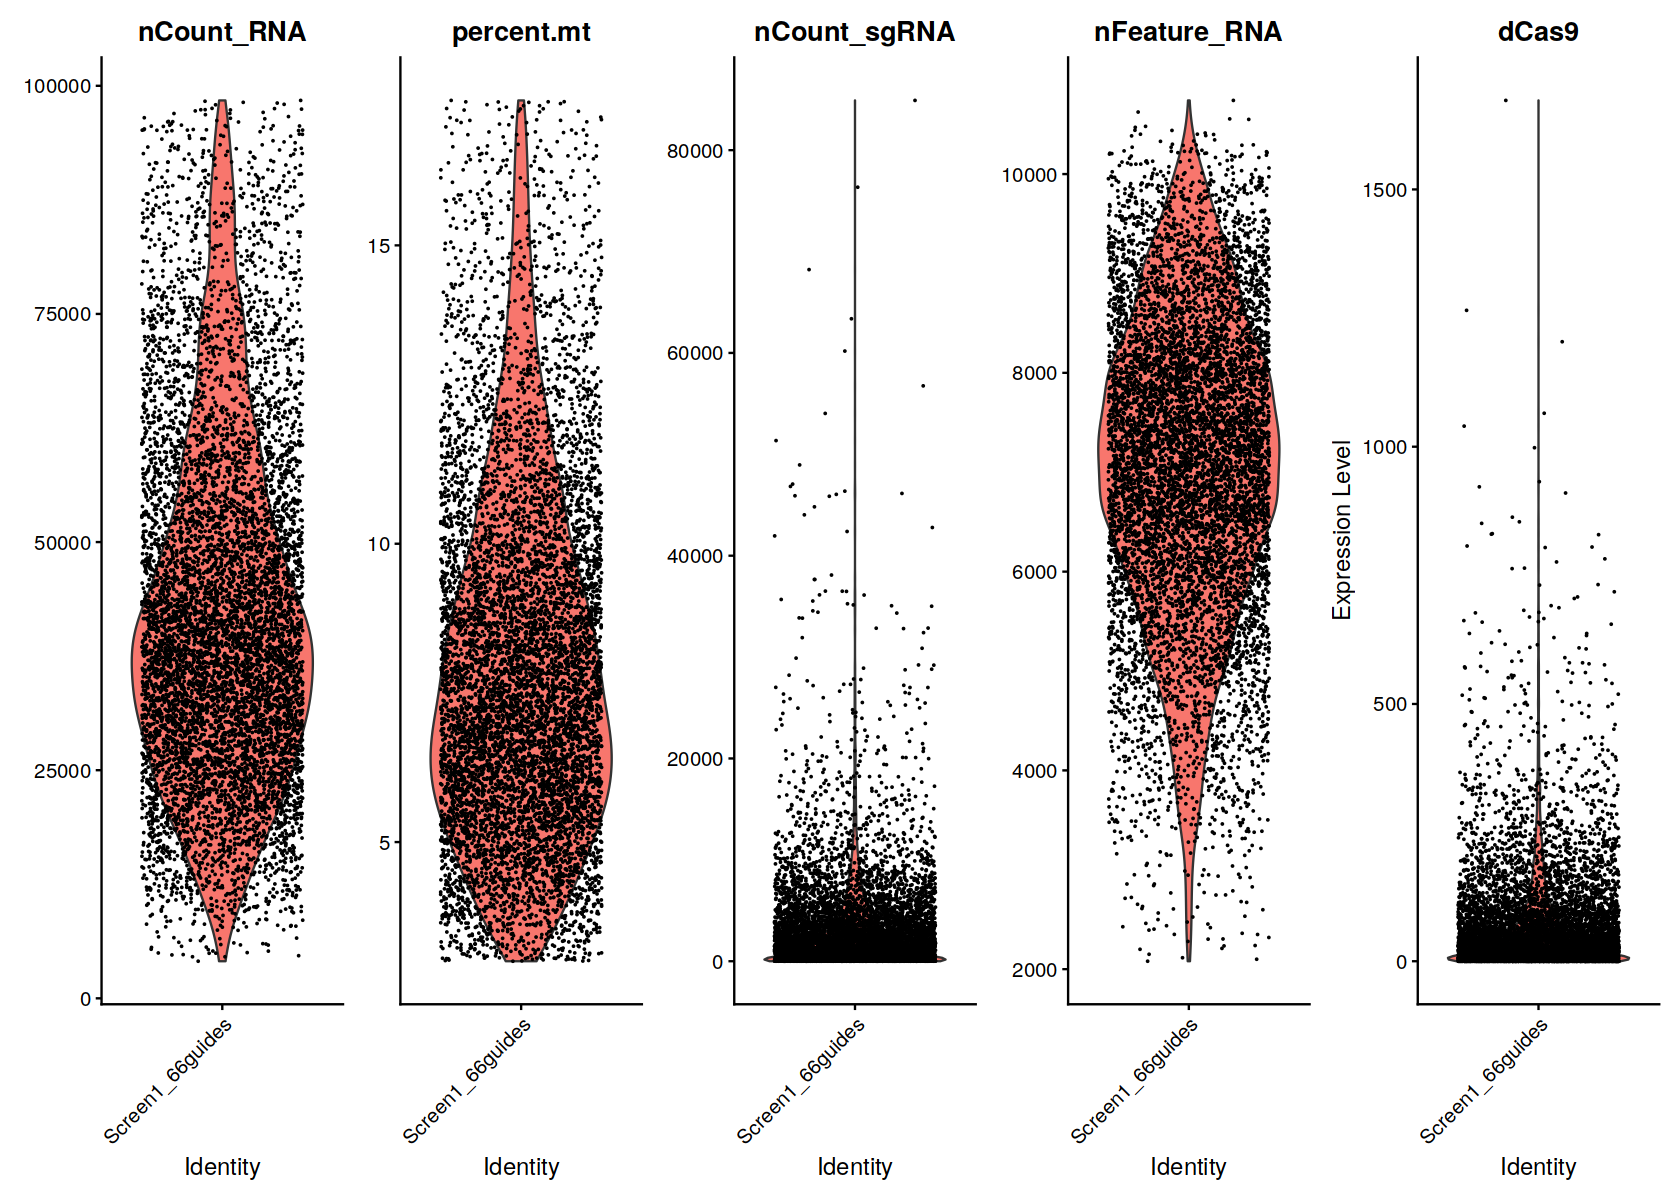

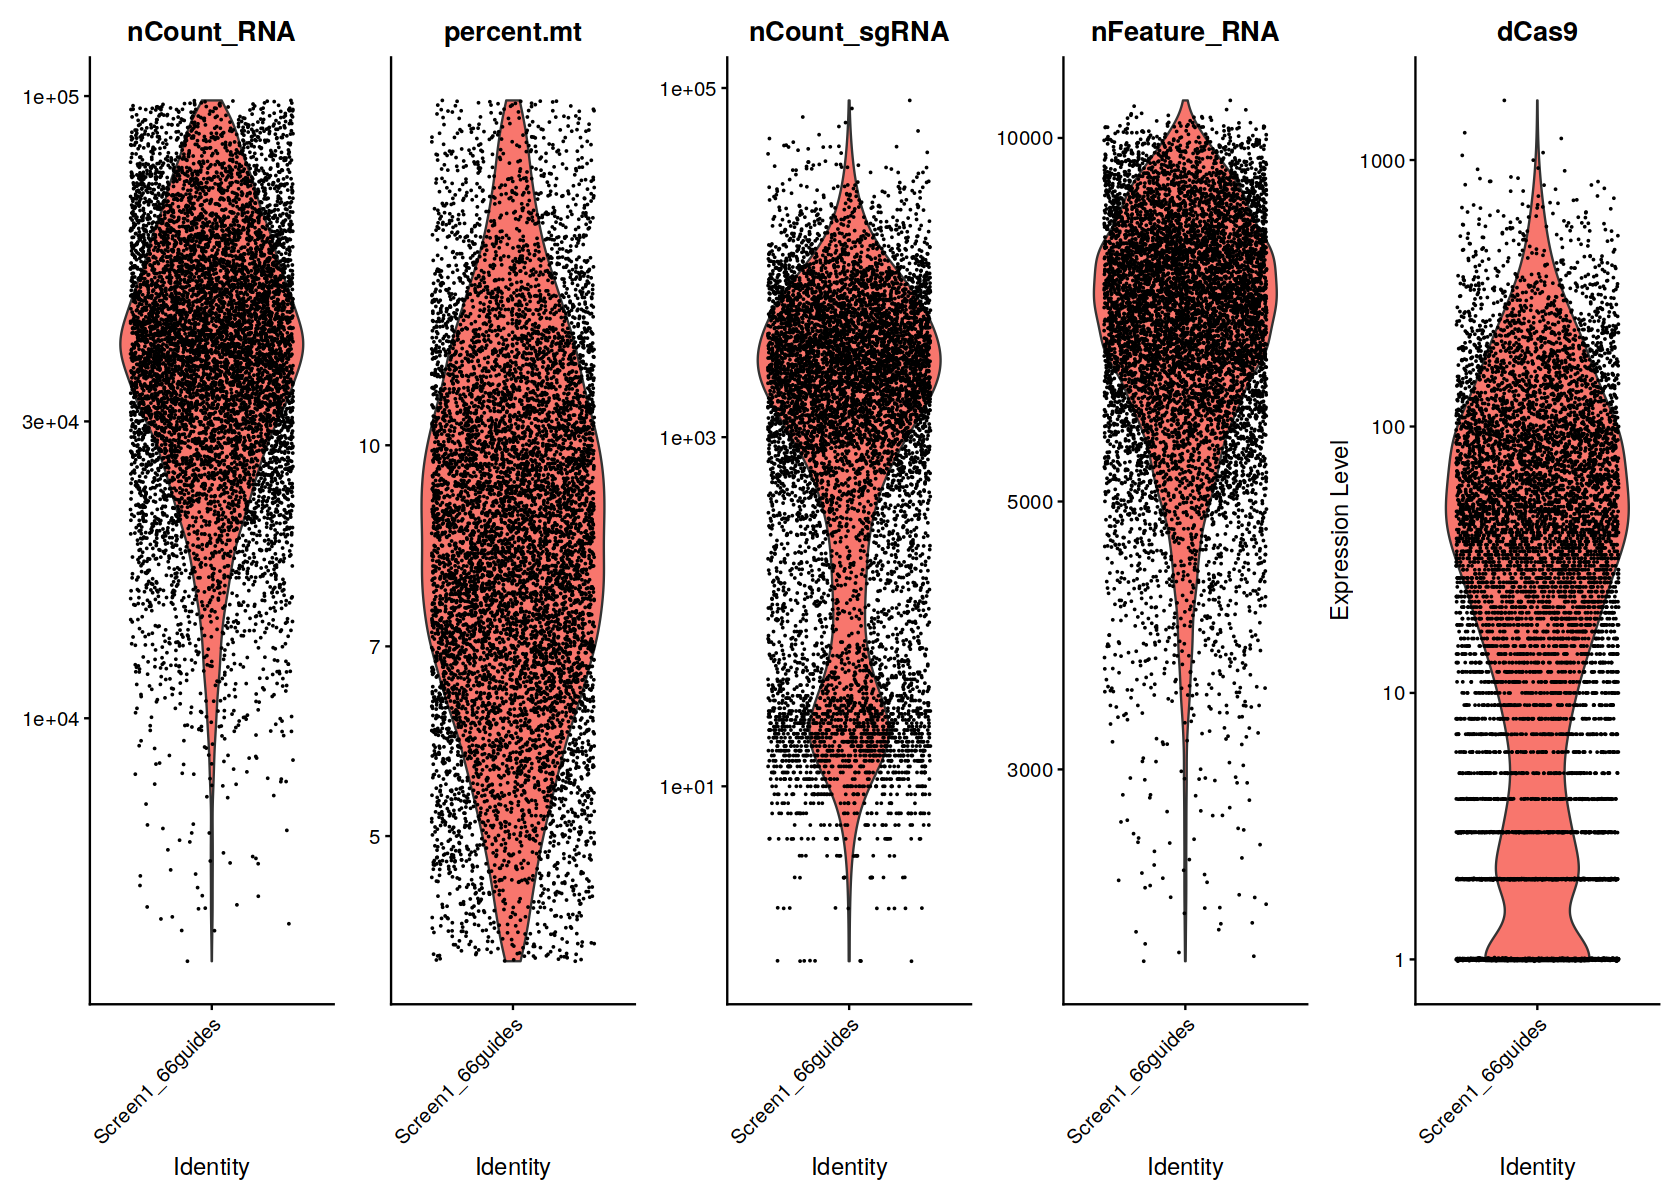

In [106]:
options(repr.plot.width=14, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"), 
        ncol = 5, 
        log = F, 
        pt.size = .01)

options(repr.plot.width=14, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA", "dCas9"), 
        ncol = 5, 
        log = T, 
        pt.size = .01)

In [107]:
remaining_cells <- nrow(seurat@meta.data)
remaining_cells

[1] 8015

## Normalization, PCA, UMAP, SVD

### Normalize RNA assay

In [46]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(
    seurat, 
    method = "glmGamPoi", 
    vst.flavor = "v2", 
    verbose = FALSE
)  %>% 
    RunPCA() %>% 
    RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)
 
#RunPCA(features = c(s.genes, g2m.genes)) %>% 
#vars.to.regress = c('S.Score', 'G2M.Score')
#vars.to.regress = "percent.mt", 


PC_ 1 
Positive:  FTL, APOE, CRYAB, MT1X, FTH1, SOD2, S100A1, PLIN2, SERPINA1, G0S2 
	   FN1, MT1E, dCas9, FGB, CTSB, RARRES2, SERPINE1, VCAM1, GPX3, NUPR1 
	   MGST1, RRAD, AKR1C3, VGF, ITPKA, IL32, SQSTM1, ZIM3, CDH6, SPP1 
Negative:  ERBB4, MECOM, KCNIP4, FAM155A, WFDC2, AC019197.1, MAL, BST2, KITLG, PDE1A 
	   SFRP1, S100A2, KRT19, PKHD1, SKAP1, CSGALNACT1, ACSL4, PCSK5, CENPF, SNED1 
	   TFCP2L1, DENND2A, TFAP2B, HOXB3, MKI67, SPON1, ITGA2, ARHGEF38, SCN2A, SGIP1 
PC_ 2 
Positive:  CENPF, MKI67, TUBA1B, TOP2A, HMGB2, TPX2, ASPM, CCNB1, DLGAP5, HMMR 
	   PCLAF, NUSAP1, CEP55, ANLN, CKS2, PBK, PRC1, PTTG1, TUBB4B, CDKN3 
	   GTSE1, H2AFZ, UBE2S, BIRC5, RRM2, CDK1, CDC20, UBE2C, CENPE, KIF20B 
Negative:  KCNIP4, MALAT1, dCas9, NEAT1, ERBB4, MECOM, AC079352.1, ADAMTS9-AS2, LINC01320, PDE1A 
	   MDM2, PTCHD4, FAM155A, LRP1B, ZIM3, PDE4D, LINC02532, PKHD1, WFDC2, MAGI2 
	   FKBP5, PKP4, AC019197.1, KCNJ16, CPEB2, FTX, GBE1, FHIT, NRXN3, PTH2R 
PC_ 3 
Positive:  WFDC2, ERBB4, KCNIP4, FXY

### Normalize sgRNA counts

In [47]:
seurat <- NormalizeData(
    seurat,
    assay = "sgRNA",
    normalization.method = "CLR"
)

Normalizing across features



Save to Seurat H5

In [48]:
# if(save_seurat_h5 == "YES") {
#     print("Saving h5...")
#     SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
# }

In [49]:
head(seurat,5)

orig.ident       nCount_RNA nFeature_RNA nCount_sgRNA
AAACCCAAGAGCAGCT-1 Screen1_66guides 25185      5887         3237        
AAACCCAAGCTTAAGA-1 Screen1_66guides 43958      7411         2844        
AAACCCAAGGCTGTAG-1 Screen1_66guides 73018      9094         1908        
AAACCCAAGGTTTACC-1 Screen1_66guides 63652      8614         2088        
AAACCCAAGTGATCGG-1 Screen1_66guides 34135      6635            7        
                   nFeature_sgRNA library percent.mt nCount_SCT nFeature_SCT
AAACCCAAGAGCAGCT-1 19             Lib_1    6.7       38025      5888        
AAACCCAAGCTTAAGA-1 31             Lib_1    9.0       40323      7326        
AAACCCAAGGCTGTAG-1 22             Lib_1   14.0       40064      7760        
AAACCCAAGGTTTACC-1 20             Lib_1    6.2       40472      8119        
AAACCCAAGTGATCGG-1  7             Lib_1   15.5       38062      6585

#### Group PS counts by construct

In [50]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
#df_guide_counts$n_guides <- rowSums(df_guide_counts)
head(df_guide_counts,2)
ncol(df_guide_counts)

CD13-1a CD13-1b CD55-1a CD55-1b CD73-1a CD73-1b FUBP1-1a FUBP1-1b C15orf40-1a
1   0       0     0       0       0       0       941      0        3          
2 882     593     0       0       0       0        20      0        0          
  C15orf40-1b ⋯ GDOC4-1a GDOC4-1b CCCE1-1a CCCE1-1b CCCE2-1a CCCE2-1b CCCE3-1a
1 0           ⋯ 0        0        0        1        0        0        0       
2 0           ⋯ 1        0        1        0        0        0        0       
  CCCE3-1b CCCE4-1a CCCE4-1b
1  0       1        0       
2 22       0        0

[1] 132

In [51]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "", ps_ids)
ps_ids <- gsub("-1b", "", ps_ids)
ps_ids <- gsub("-2a", "", ps_ids)
ps_ids <- gsub("-2b", "", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"

[1] 42

In [52]:
df_guides_by_target <- df_guide_counts[, ps_ids]
df_guides_by_target$total_targets <- rowSums(df_guides_by_target!=0)
head(df_guides_by_target)
ncol(df_guides_by_target)

CD13 CD55 CD73 FUBP1 C15orf40 MAFF FTH1 PLIN3 TKT  LGALS3 ⋯ NTCE4 GDOC1 GDOC2
1    0 0    0    941   3        1     0   0        0 0      ⋯ 0     0     0    
2 1475 0    0     20   0        0     0   0        0 2      ⋯ 4     0     0    
3    0 1    0      1   0        0     1   0     1887 0      ⋯ 1     0     0    
4    2 0    1      1   0        0     0   0        1 0      ⋯ 0     0     0    
5    0 0    0      0   0        0     0   1        1 0      ⋯ 0     0     0    
6  359 0    0      0   0        0    39   3        0 6      ⋯ 0     0     0    
  GDOC3 GDOC4 CCCE1 CCCE2 CCCE3 CCCE4 total_targets
1 0     0        1  0      0    1     16           
2 0     1        1  0     22    0     22           
3 0     1        0  1      0    0     18           
4 0     1        1  0      0    0     19           
5 0     0        0  0      0    0      7           
6 0     1     2367  0      1    1     27

[1] 43

In [53]:
#sum(df_guides_by_target[, 'NTCE2'] > 0)

#### Group PS counts by construct

In [54]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "-1", ps_ids)
ps_ids <- gsub("-1b", "-1", ps_ids)
ps_ids <- gsub("-2a", "-2", ps_ids)
ps_ids <- gsub("-2b", "-2", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13-1"     "CD55-1"     "CD73-1"     "FUBP1-1"    "C15orf40-1"
 [6] "MAFF-1"     "FTH1-1"     "FTH1-2"     "PLIN3-1"    "PLIN3-2"   
[11] "TKT-1"      "TKT-2"      "LGALS3-1"   "LGALS3-2"   "CSTB-1"    
[16] "CSTB-2"     "CTSB-1"     "CTSB-2"     "KLF6-1"     "KLF6-2"    
[21] "DE1-1"      "DE1-2"      "DE2-1"      "DE2-2"      "DE3-1"     
[26] "DE3-2"      "DE4-1"      "DE4-2"      "DE5-1"      "DE5-2"     
[31] "DE6-1"      "DE6-2"      "DE7-1"      "DE7-2"      "DE8-1"     
[36] "DE8-2"      "DE9-1"      "DE9-2"      "DE10-1"     "DE10-2"    
[41] "DE11-1"     "DE11-2"     "DE12-1"     "DE12-2"     "DE13-1"    
[46] "DE13-2"     "DE14-1"     "DE14-2"     "DE15-1"     "DE15-2"    
[51] "DE16-1"     "DE16-2"     "DE17-1"     "DE17-2"     "NTCE1-1"   
[56] "NTCE2-1"    "NTCE3-1"    "NTCE4-1"    "GDOC1-1"    "GDOC2-1"   
[61] "GDOC3-1"    "GDOC4-1"    "CCCE1-1"    "CCCE2-1"    "CCCE3-1"   
[66] "CCCE4-1"

[1] 66

In [55]:
df_guides_by_vector <- df_guide_counts[, ps_ids]
df_guides_by_vector$total_vectors <- rowSums(df_guides_by_vector!=0)
head(df_guides_by_vector)
ncol(df_guides_by_vector)

CD13-1 CD55-1 CD73-1 FUBP1-1 C15orf40-1 MAFF-1 FTH1-1 FTH1-2 PLIN3-1 PLIN3-2
1    0   0      0      941     3          1      0       0     0       0      
2 1475   0      0       20     0          0      0       0     0       0      
3    0   1      0        1     0          0      0       1     0       0      
4    2   0      1        1     0          0      0       0     0       0      
5    0   0      0        0     0          0      0       0     1       0      
6  359   0      0        0     0          0      4      35     3       0      
  ⋯ NTCE4-1 GDOC1-1 GDOC2-1 GDOC3-1 GDOC4-1 CCCE1-1 CCCE2-1 CCCE3-1 CCCE4-1
1 ⋯ 0       0       0       0       0          1    0        0      1      
2 ⋯ 4       0       0       0       1          1    0       22      0      
3 ⋯ 1       0       0       0       1          0    1        0      0      
4 ⋯ 0       0       0       0       1          1    0        0      0      
5 ⋯ 0       0       0       0       0          0    0        0      0      
6 ⋯ 0       0       0       0       1       2367    0        1      1      
  total_vectors
1 18           
2 26           
3 21           
4 19           
5  6           
6 32

[1] 67


## Plot PS b vs a before demux

In [56]:
guide_names = sort(colnames(df_guide_counts))
guides_a = guide_names[grep('a$', guide_names)]
guides_b = guide_names[grep('b$', guide_names)]

Count a and b guides for each target

In [57]:
df_pair = df_guide_counts
df_pair_a = gather(df_pair[, guides_a], key="PS_a", value="a")
df_pair_b = gather(df_pair[, guides_b], key="PS_b", value="b")

df_pair = cbind(df_pair_a, df_pair_b)
head(df_pair,2 )

PS_a        a PS_b        b
1 C15orf40-1a 3 C15orf40-1b 0
2 C15orf40-1a 0 C15orf40-1b 0

Get a and b sums for each target

In [58]:
df_a_sums = df_pair %>% group_by(PS_a) %>% summarise(Freq = sum(a)) 
df_a_sums$PS_a = gsub("a$", "", as.vector(df_a_sums$PS_a))
colnames(df_a_sums) = c("Target", "a")

df_b_sums = df_pair %>% group_by(PS_b) %>% summarise(Freq = sum(b))
df_b_sums$PS_b = gsub("b$", "", as.vector(df_b_sums$PS_b))
colnames(df_b_sums) = c("Target", "b")

df_sums = merge(df_a_sums, df_b_sums, on=Target)

head(df_sums)
write.table(df_sums, "/home/vsevim/prj/1012-ckd/S1/analysis/folding/guide_count_sums.tsv", row.names=FALSE, quote=FALSE, sep="\t")

Target     a      b     
1 C15orf40-1 288910 430267
2 CCCE1-1    285546 235922
3 CCCE2-1    435695  82944
4 CCCE3-1    185280 265997
5 CCCE4-1    268232  17578
6 CD13-1     110837  94006

In [59]:
df_pair$PS = gsub("a$", "", as.vector(df_pair$PS_a))
df_pair = subset(df_pair, select = c(PS, a, b))

select_nonzero = (df_pair$a > 0) | (df_pair$b > 0)
df_pair = df_pair[select_nonzero, ]
rownames(df_pair) <- NULL

Count a=0, b>0 pairs, a>0 b=0 pairs

In [60]:
select_zero_a_nonzero_b = (df_pair$a == 0) & (df_pair$b  > 0)
select_nonzero_a_zero_b = (df_pair$a  > 0) & (df_pair$b == 0)

df_zero_a  = df_pair[select_zero_a_nonzero_b, ]
df_zero_b  = df_pair[select_nonzero_a_zero_b, ]

df_zero_a_counts = data.frame(table(df_zero_a$PS))
df_zero_b_counts = data.frame(table(df_zero_b$PS))
df_all_counts    = data.frame(table(df_pair$PS))

In [61]:
head(df_all_counts,2)
head(df_zero_a_counts,2)
head(df_zero_b_counts,2)

Var1       Freq
1 C15orf40-1 4431
2 CCCE1-1    4042

Var1       Freq
1 C15orf40-1 1400
2 CCCE1-1    1153

Var1       Freq
1 C15orf40-1 1511
2 CCCE1-1    1571

In [62]:
df_list <- list(df_zero_a_counts, df_zero_b_counts, df_all_counts)

#merge all data frames in list
df_zero_counts = df_list %>% reduce(full_join, by='Var1') 
colnames(df_zero_counts) = c("Target", "zero_a_nonzero_b", "zero_b_nonzero_a", "total")
df_zero_counts$perc_zero_a = 100 * df_zero_counts$zero_a_nonzero_b/df_zero_counts$total
df_zero_counts$perc_zero_b = 100 * df_zero_counts$zero_b_nonzero_a/df_zero_counts$total
head(df_zero_counts)


Target     zero_a_nonzero_b zero_b_nonzero_a total perc_zero_a perc_zero_b
1 C15orf40-1 1400             1511             4431  31.6        34         
2 CCCE1-1    1153             1571             4042  28.5        39         
3 CCCE2-1     339             2753             3774   9.0        73         
4 CCCE3-1    1157             1113             3258  35.5        34         
5 CCCE4-1     134             2665             3129   4.3        85         
6 CD13-1      737             1052             2322  31.7        45

In [63]:
df_dummy = df_zero_counts %>% select(Target, perc_zero_a, perc_zero_b) %>%
  pivot_longer(., cols = c(perc_zero_a, perc_zero_b), names_to = "Category", values_to = "percentage")

In [64]:
head(df_dummy)

Target     Category    percentage
1 C15orf40-1 perc_zero_a 32        
2 C15orf40-1 perc_zero_b 34        
3 CCCE1-1    perc_zero_a 29        
4 CCCE1-1    perc_zero_b 39        
5 CCCE2-1    perc_zero_a  9        
6 CCCE2-1    perc_zero_b 73

Warning message:
"Removed 3 rows containing missing values (`geom_bar()`)."


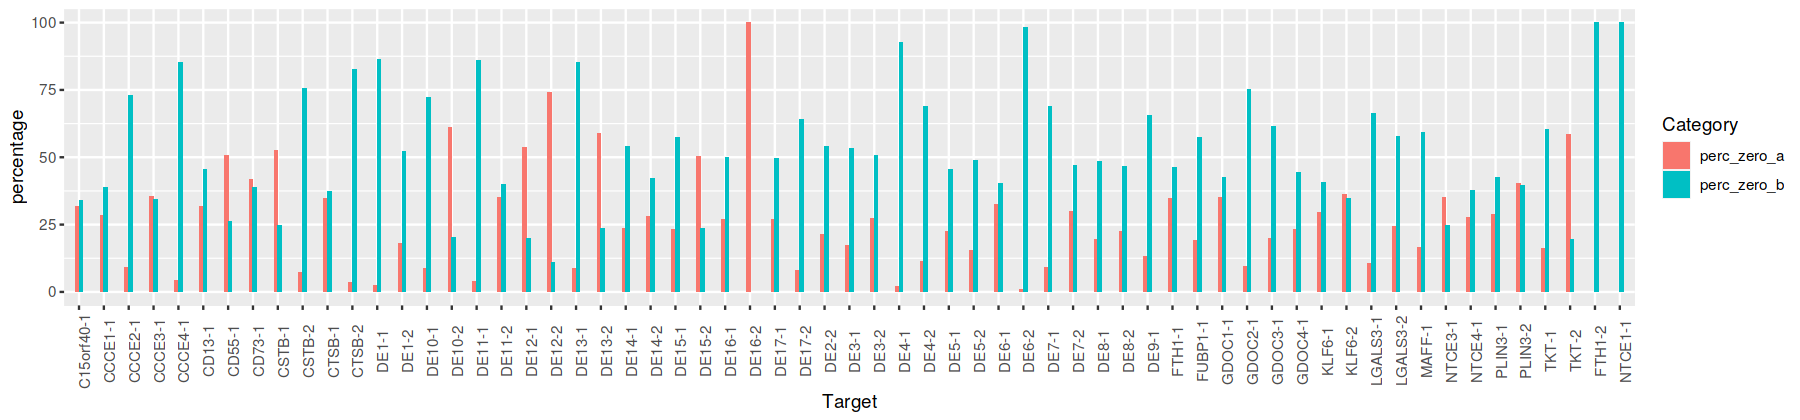

In [65]:
options(repr.plot.width=15, repr.plot.height=3.5)

ggplot(df_dummy, aes(fill=Category, y=percentage, x=Target)) +
    geom_bar(position='dodge', stat='identity', width=0.3) +
    theme(axis.text.x = element_text(angle = 90))


End debug

In [66]:
### Plot ditributions for 

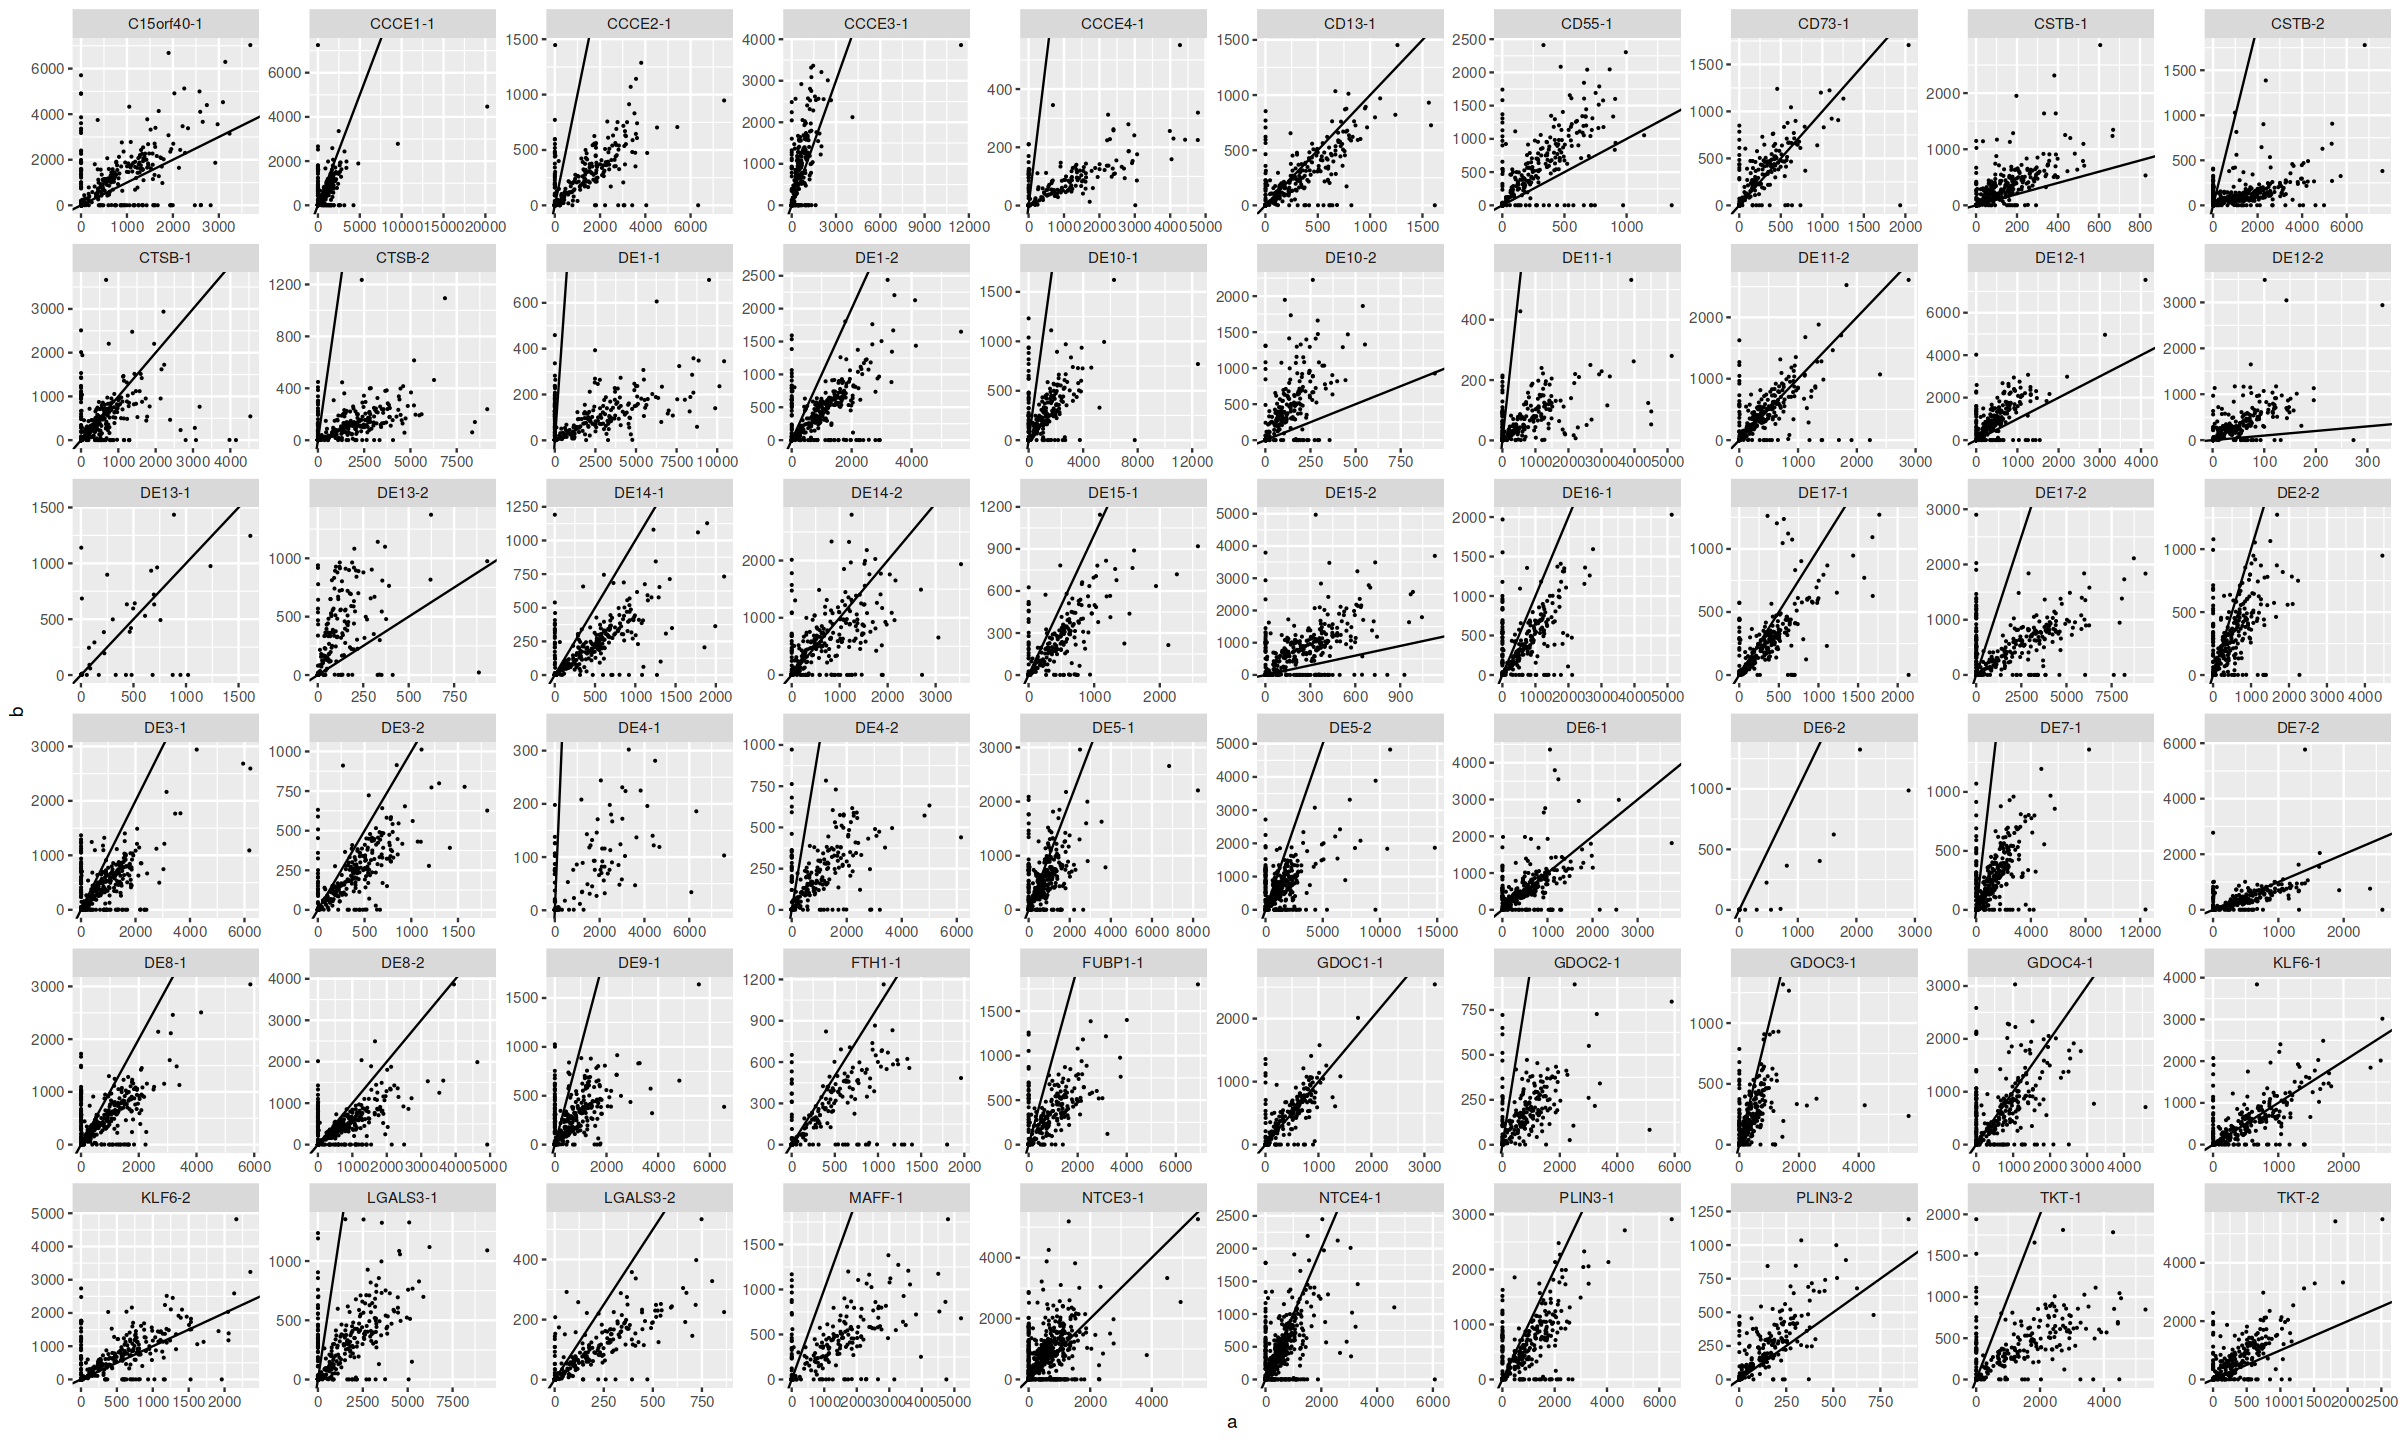

In [67]:
select_nonzero = (df_pair$a > 0) & (df_pair$b > 0)
df_pair = df_pair[select_nonzero,]

options(repr.plot.width=20, repr.plot.height=12)

p1 <- ggplot(df_pair, aes(x=a, y=b)) +
    geom_point(size=.1) +
    geom_abline(slope=1, intercept = 0) +
    facet_wrap(~ PS, scales="free", ncol = 10)

p1

### Visualize guide count distribution before demux

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 8 rows containing non-finite values (`stat_bin()`)."


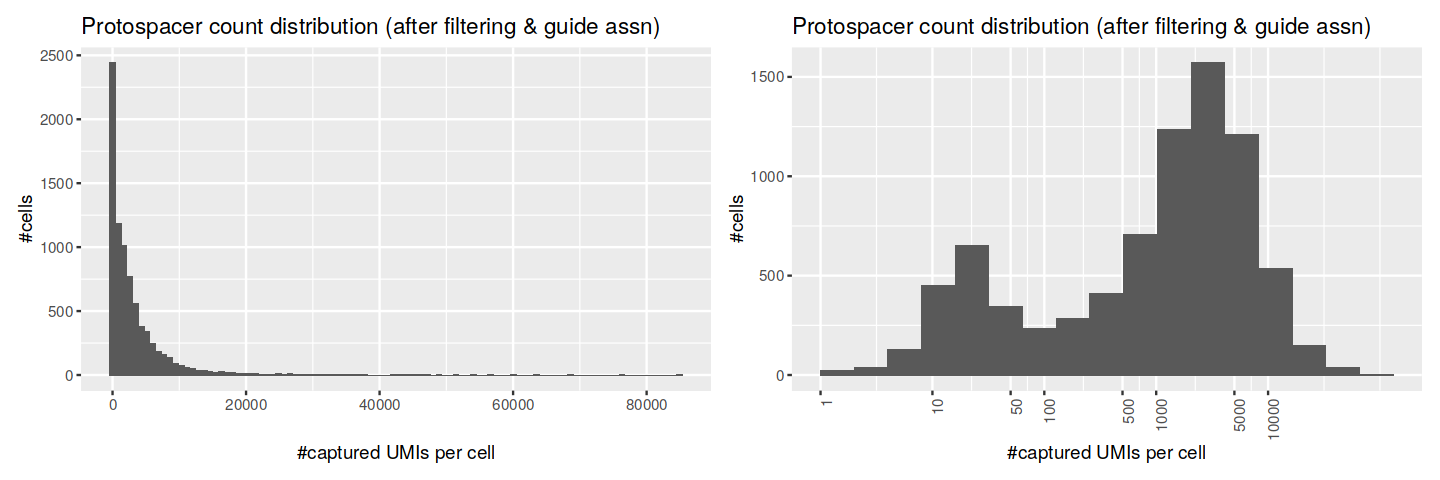

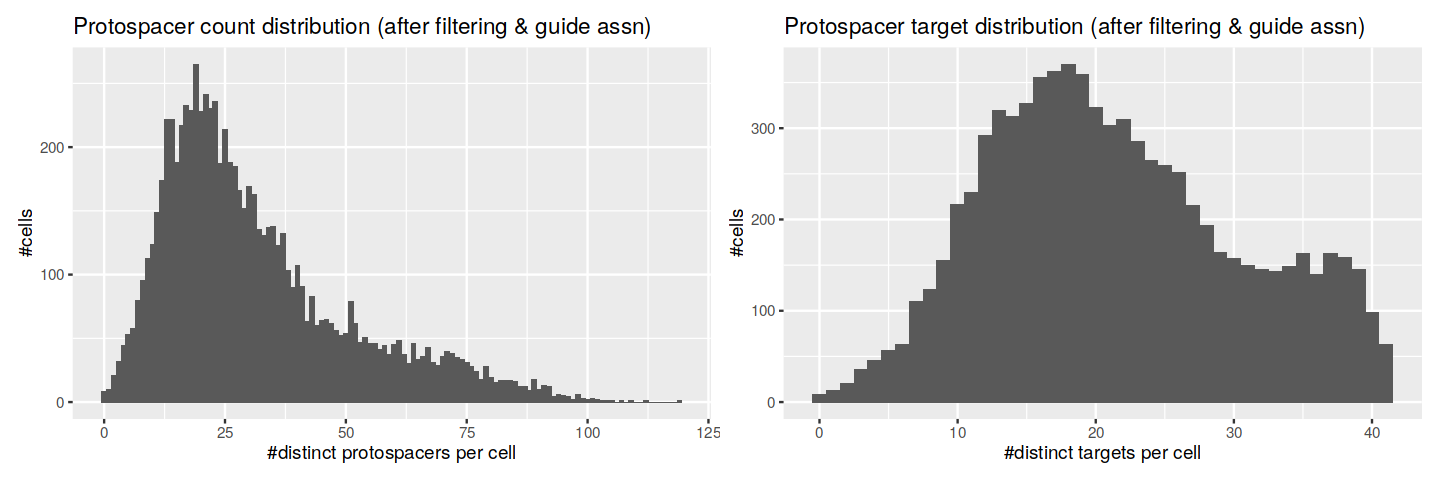

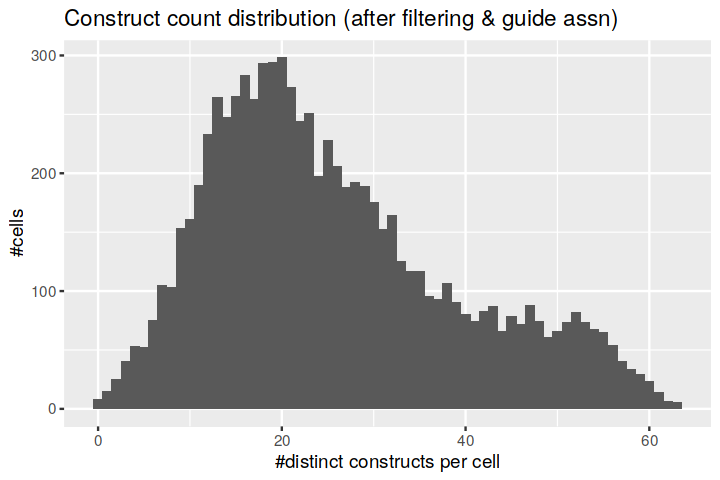

In [68]:
df_seurat <- seurat[[]]
bin_breaks <- c(1,2,2*2^(1:16))

p1 <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(bins=100) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#captured UMIs per cell") +
    labs(y = "#cells") 

p1b <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(breaks=bin_breaks) +
    scale_x_log10(breaks=c(1,10,50,100,500,1000,5000,10000)) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#captured UMIs per cell") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

p2 <- ggplot(df_seurat, aes(x = nFeature_sgRNA)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#distinct protospacers per cell") +
    labs(y = "#cells") 

p3 <- ggplot(df_guides_by_target, aes(x = total_targets)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer target distribution (after filtering & guide assn)", x = "#distinct targets per cell") +
    labs(y = "#cells") 


p4 <- ggplot(df_guides_by_vector, aes(x = total_vectors)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (after filtering & guide assn)", x = "#distinct constructs per cell") +
    labs(y = "#cells") 

options(repr.plot.width=12, repr.plot.height=4)
p1 | p1b
p2 | p3
options(repr.plot.width=6, repr.plot.height=4)
p4

### Visualize guide count distribution before demux (Cellranger guide assignments. I don't use these.)

In [69]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

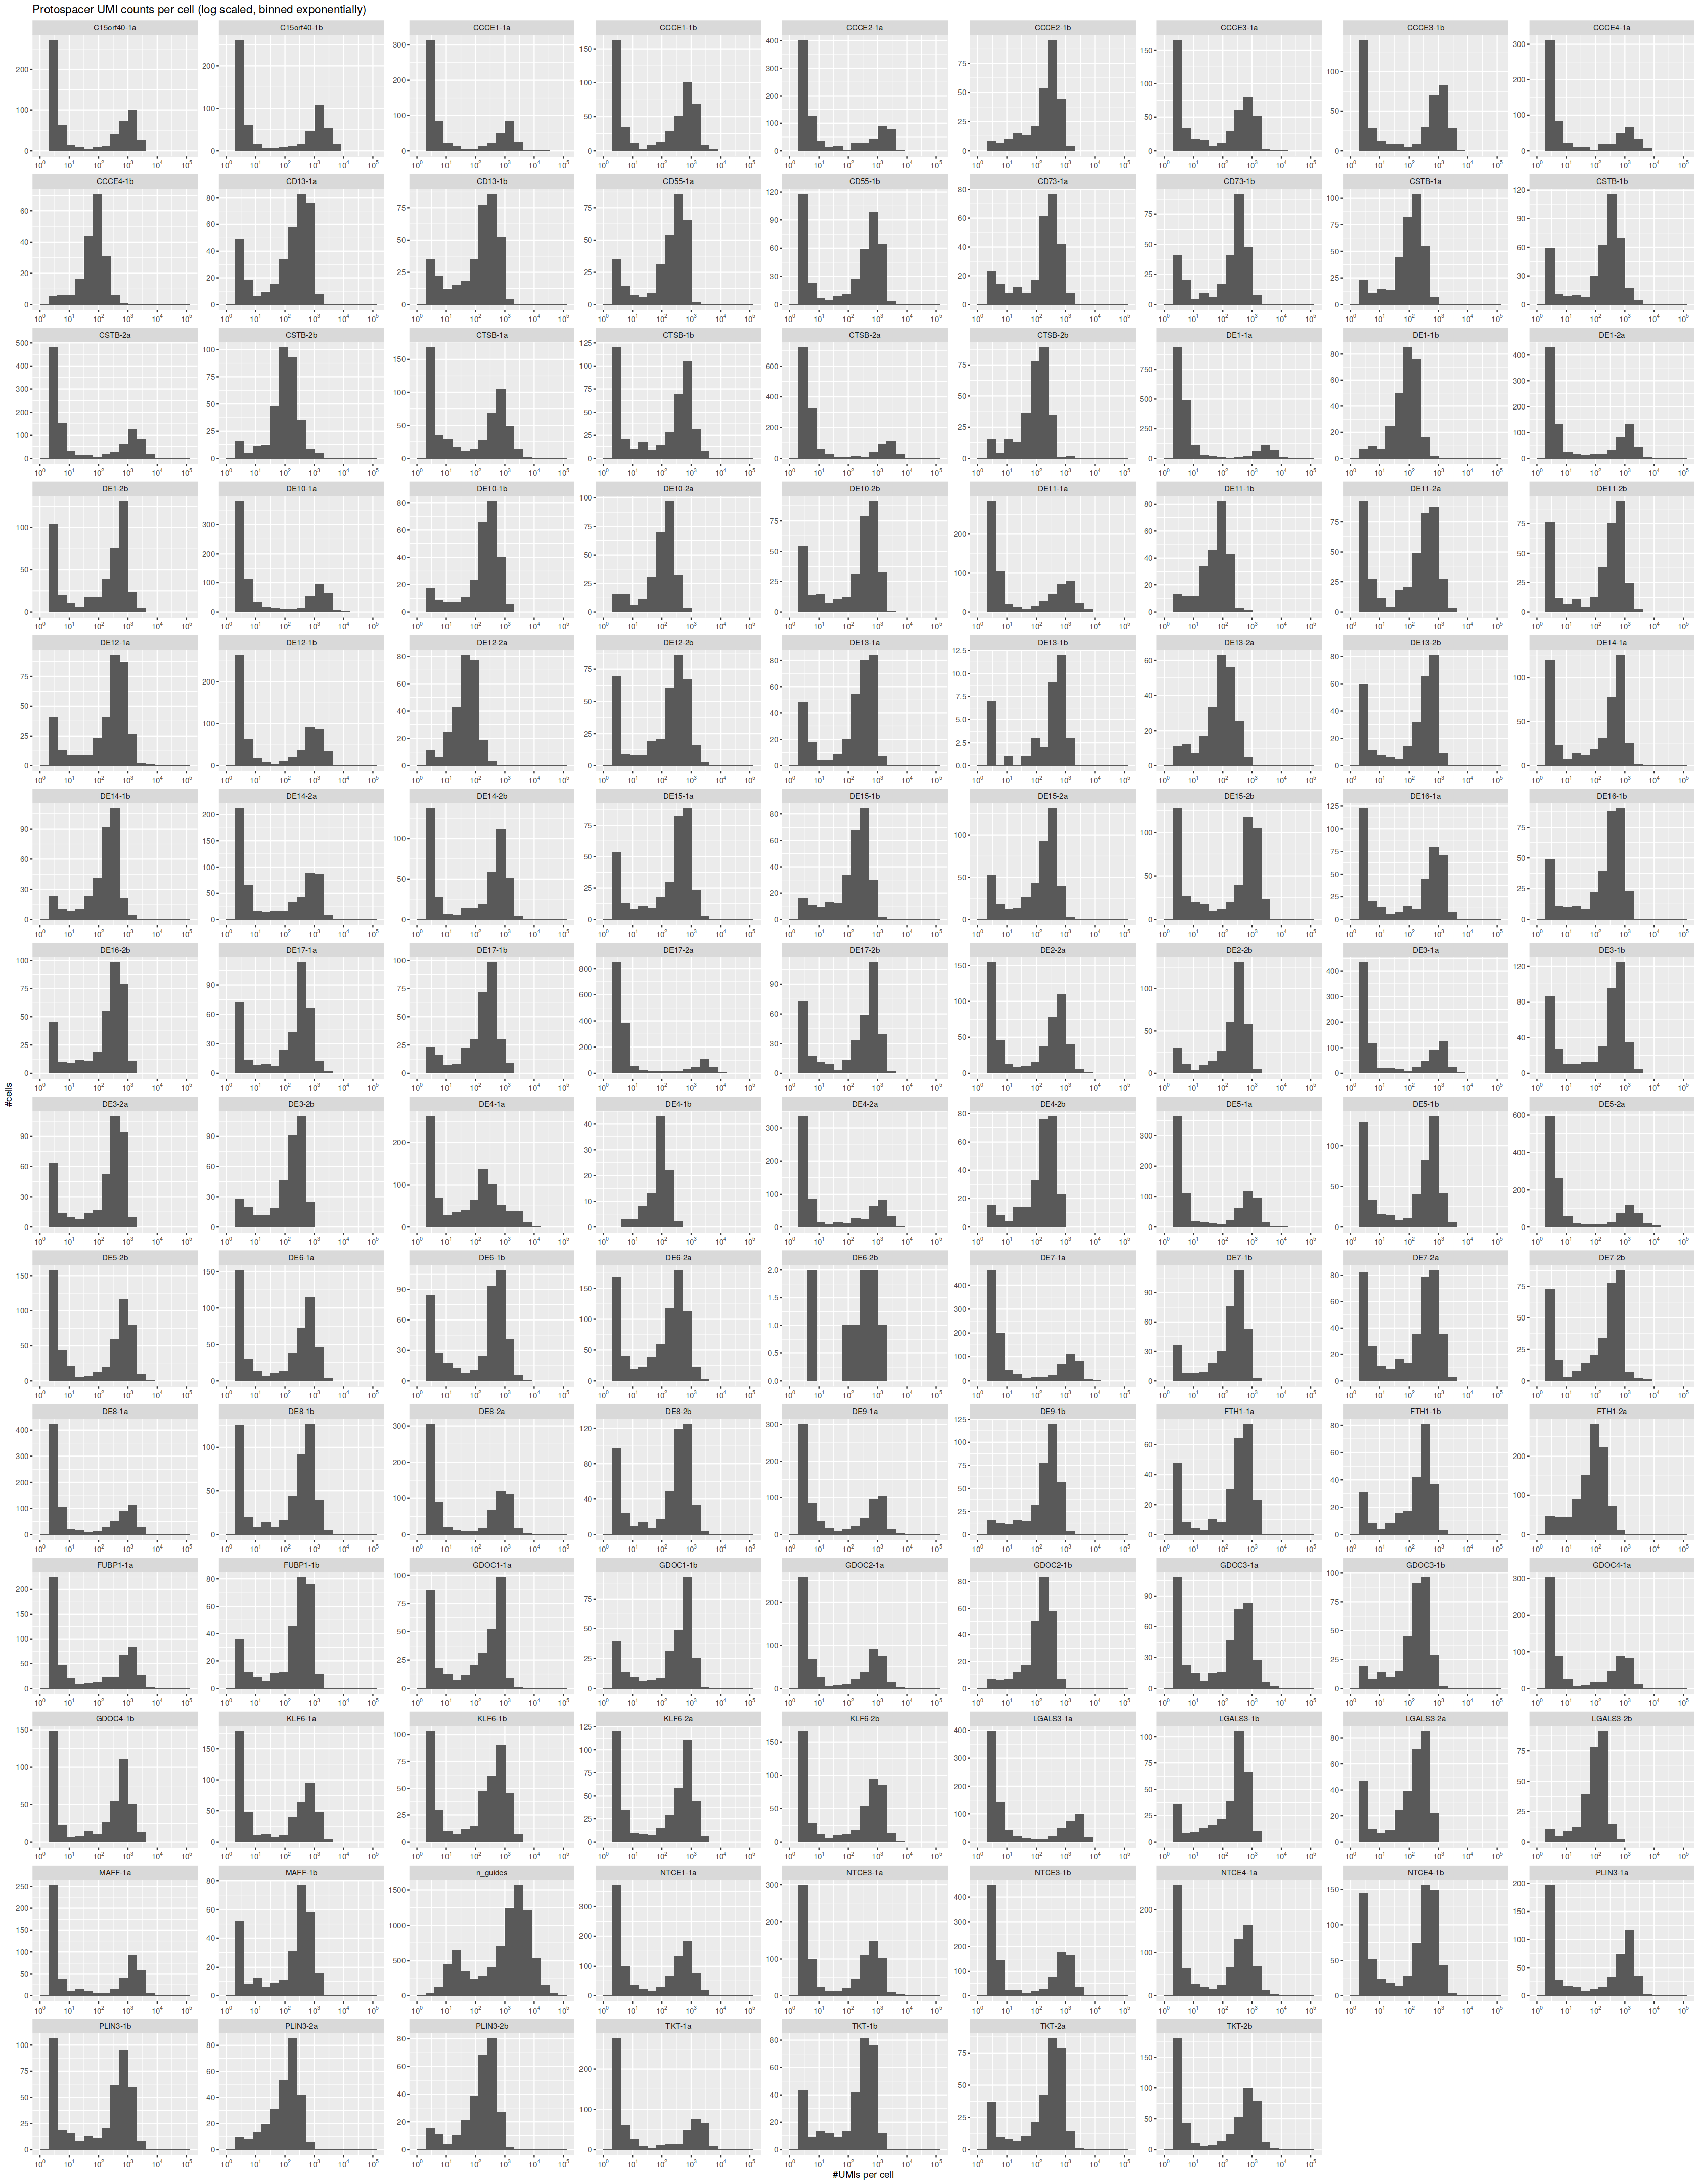

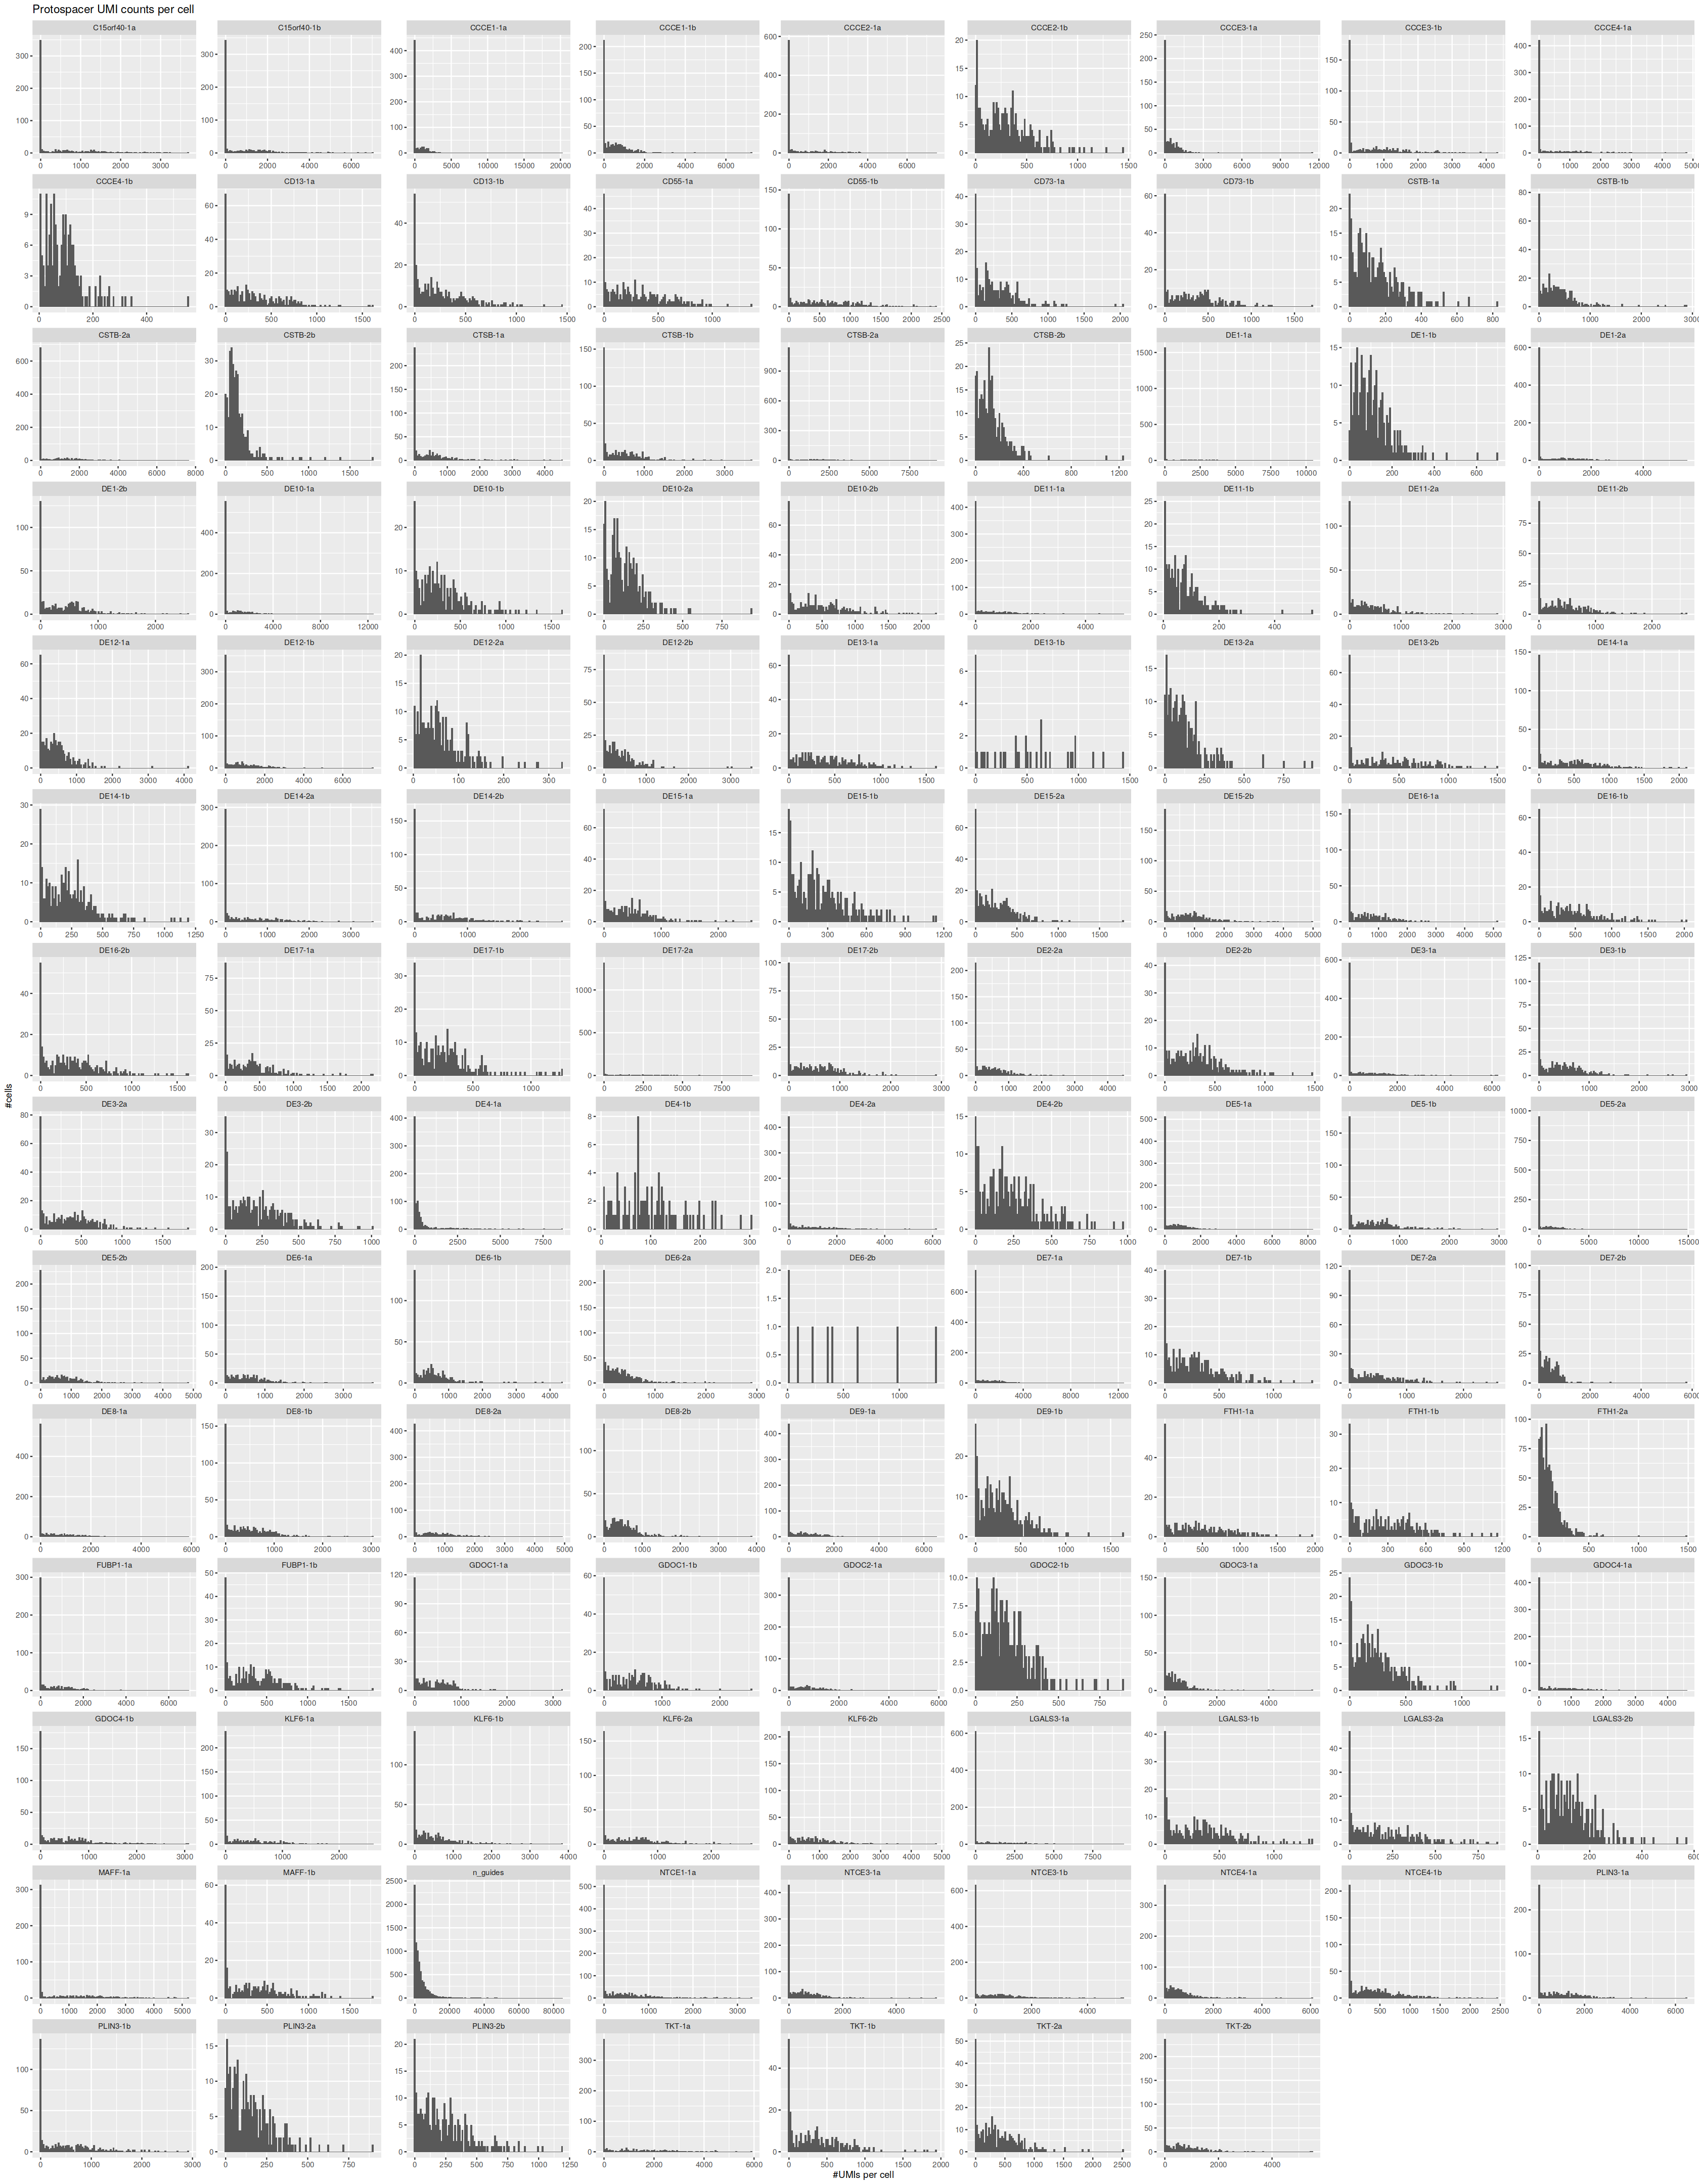

In [70]:
options(repr.plot.width=28, repr.plot.height=36)

data_long <- df_guide_counts %>%                    
  pivot_longer(colnames(df_guide_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp1
ggp2

# Load Souporcell outputs

In [71]:
df_soup = read.csv(souporcell_clusters_path, sep="\t")
head(df_soup,2)
sum(df_soup=='singlet')

barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCAAGAGCAGCT-1 singlet 3           -695               -837           
2 AAACCCAAGCCGGAAT-1 doublet 1/2        -6694              -4669           
  cluster0 cluster1 cluster2 cluster3
1 -2104    -2279    -2433      -695  
2 -8876    -6694    -6876    -11522

[1] 8171

## Assign singlet/doubletstatus to Seurat cells

In [72]:
df_meta <- seurat@meta.data
df_meta$barcode <- rownames(df_meta)
df_assignment   <- subset(df_soup, select=c('barcode', 'status', 'assignment'))

#df_dummy <- merge(df_meta, df_assignment, on='barcode')
df_dummy <- inner_join(df_meta, df_assignment, by='barcode')
nrow(df_meta)
nrow(df_dummy)
#head(df_meta)
#head(df_dummy)


[1] 8015

[1] 8015

In [73]:
seurat$status = df_dummy$status
seurat$donor  = df_dummy$assignment

Check if join worked ok

In [74]:
rownames(df_soup) = df_soup$barcode
any(df_soup[rownames(seurat@meta.data), 'status'] != seurat@meta.data$status)

[1] FALSE

Get souporcell assginment counts

In [75]:
table(df_soup$status)


   doublet    singlet unassigned 
       918       8171         80 

### Eliminate doublets

How many doublets among the filtered cells? 

In [76]:
select_doublets = (df_soup$status == 'doublet')
doublet_cells   = df_soup[select_doublets,]$barcode
seurat_cells    = Cells(seurat)

select_singlets = (df_soup$status == 'singlet')
singlet_cells   = df_soup[select_singlets,]$barcode
seurat = subset(seurat, cells=singlet_cells)

stats[["Doublets_in_filtered_cells"]] = length(intersect(doublet_cells, seurat_cells))
stats[["Total_doublets_before_filtering"]] = length(doublet_cells)
stats[["Singlets_after_filtering"]] = length(Cells(seurat))
stats[["Singlets_perc_after_filtering"]] = round(length(Cells(seurat))/length(seurat_cells),2)

### Add stats into the misc slot

In [77]:
Misc(seurat, slot = 'stats') <- stats

In [78]:
unique(seurat$status)

[1] "singlet"

#### Add dCas9 counts to metadata

In [ ]:
barcodes = rownames(seurat@meta.data)
seurat$dCas9 = t(seurat[['RNA']]["dCas9",])[barcodes,]

[1] 0

# Save to Seurat H5

In [79]:
if(save_seurat_h5 == "YES") {
    print("Saving h5...")
    SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
}

In [80]:
save_h5_file

[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/Screen1_66guides_Lib_1.h5seurat"

# Stats

In [81]:
for(stat in names(stats)){
    cat(blue(stat), ":", stats[[stat]], "\n")
}

Screen : Screen1_66guides 
Library : Lib_1 
Cells_recovered : 9183 
Genes_recovered : 31871 
Protospacers_in_assay : 132 
Max_mito_perc_threshold : 17 
Min_mito_perc_threshold : 3 
Max_n_RNA_threshold : 98499 
Min_n_RNA_threshold : -22205 
Max_n_genes_threshold : 12196 
Min_n_genes_threshold : 2000 
Cells_after_QC_filtering : 8015 
Cells_with_sgRNA_count_less_than_100 : 1786 
Doublets_in_filtered_cells : 719 
Total_doublets_before_filtering : 918 
Singlets_after_filtering : 7295 
Singlets_perc_after_filtering : 0.91 


In [82]:
stats_fname = paste0(stats_out_path, library_name, "_stats.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(stats, file=stats_fname, quote=FALSE, sep='\t', col.names = NA)

In [83]:
unique(subset(seurat, cells=singlet_cells)$status)
unique(seurat$status)

[1] "singlet"

[1] "singlet"

#  Clustering QC

## Is clustering driven by UMI counts?

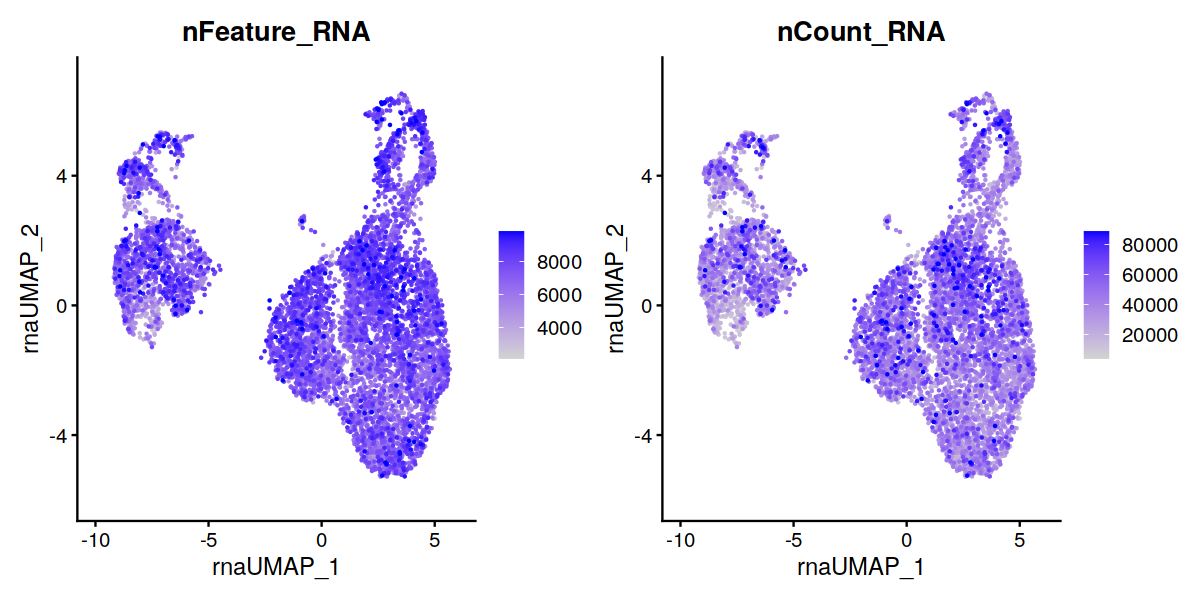

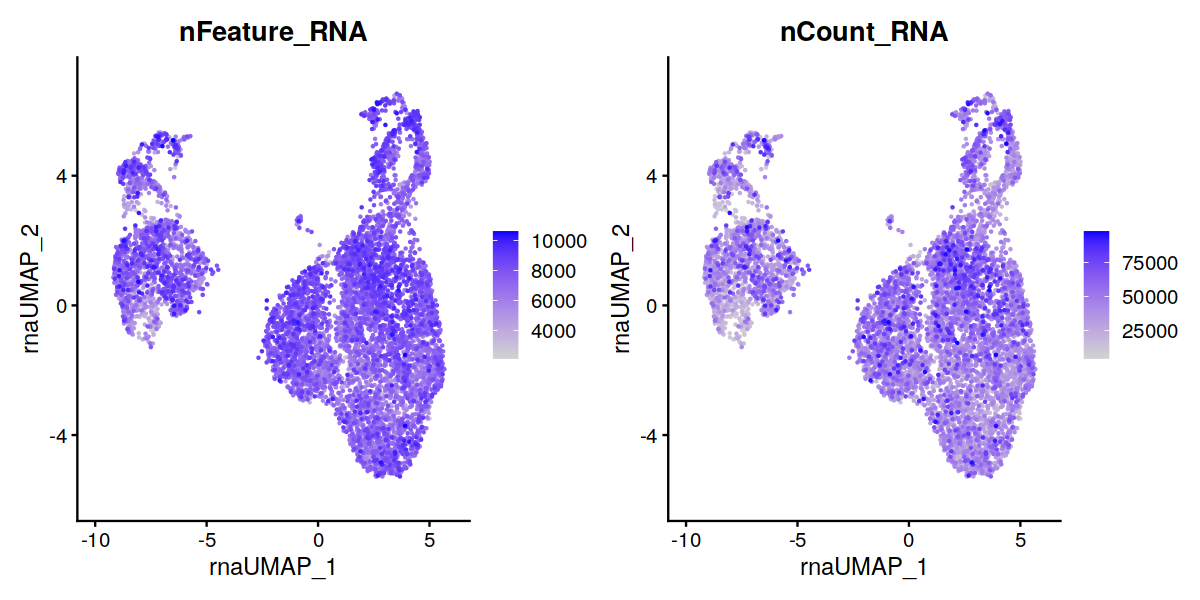

In [84]:
options(repr.plot.width=10, repr.plot.height=5)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("nFeature_RNA", "nCount_RNA"), 
    min.cutoff = NA, 
    max.cutoff = "q99", 
    ncol = 2, 
    order=T
)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("nFeature_RNA", "nCount_RNA"), 
    min.cutoff = NA, 
    max.cutoff = NA, 
    ncol = 2, 
    order=T
)

### Check if mito reads are driving the clustering

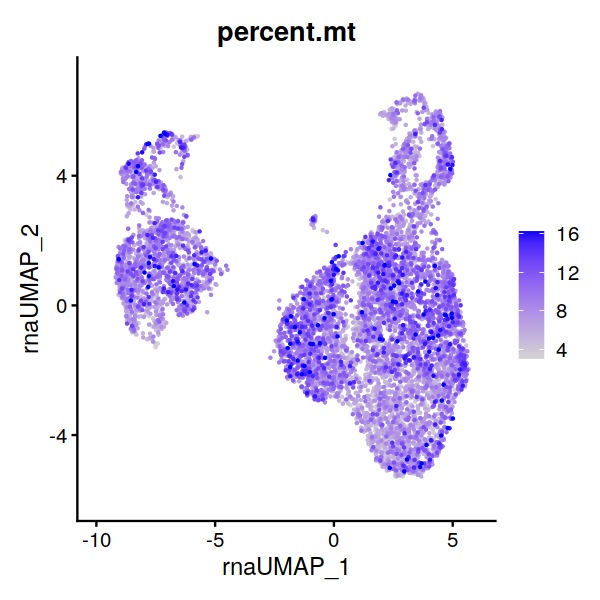

In [85]:
options(repr.plot.width=5, repr.plot.height=5)
FeaturePlot(seurat, reduction= "umap.rna", features = c("percent.mt"), min.cutoff = NA, max.cutoff = "q99", order=T)

# Stop

In [86]:
quit(save="no")

# -------

# Check the effect of the cell cycle

In [87]:
seurat <- CellCycleScoring(
    seurat, 
    s.features = s.genes, 
    g2m.features = g2m.genes, 
    set.ident = TRUE,
    assay = 'SCT'
)

Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"


Regress out the cell cylce effects

In [88]:
# DefaultAssay(seurat) <- "RNA"
# seurat <- SCTransform(
#     seurat, 
#     vst.flavor = "v2", 
#     verbose = FALSE, 
#     vars.to.regress = c('S.Score', 'G2M.Score')
# )  %>% 
#     RunPCA(features = c(s.genes, g2m.genes)) %>% 
#     RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

Alternatively use this

In [89]:
#seurat <- RunPCA(seurat, features = c(s.genes, g2m.genes))

Picking joint bandwidth of 0.12

Picking joint bandwidth of 0.154

Picking joint bandwidth of 0.0868

Picking joint bandwidth of 0.101



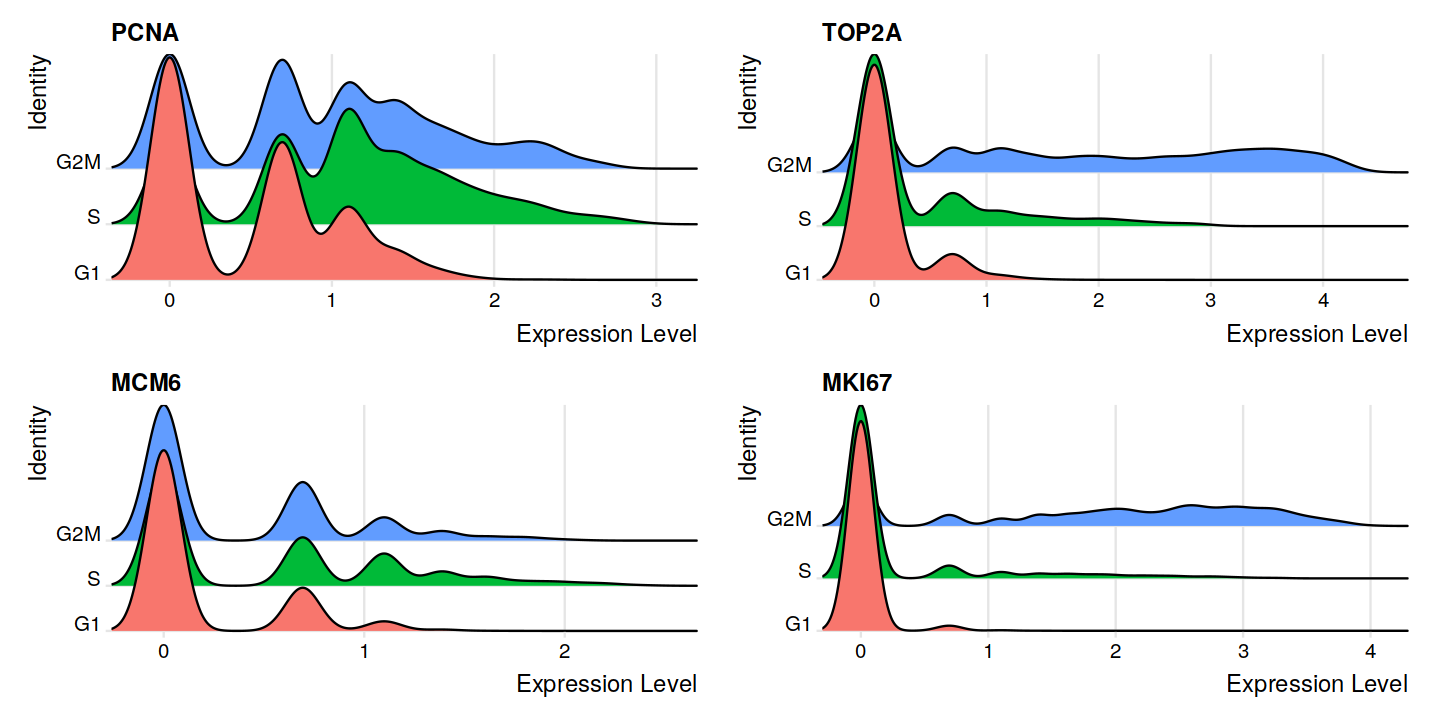

In [90]:
# Visualize the distribution of cell cycle markers across
options(repr.plot.width=12, repr.plot.height=6)
DefaultAssay(seurat) <- "SCT"
RidgePlot(seurat, features = c("PCNA", "TOP2A", "MCM6", "MKI67"), ncol = 2)

In [91]:
length(s.genes)
length(g2m.genes)

[1] 43

[1] 54

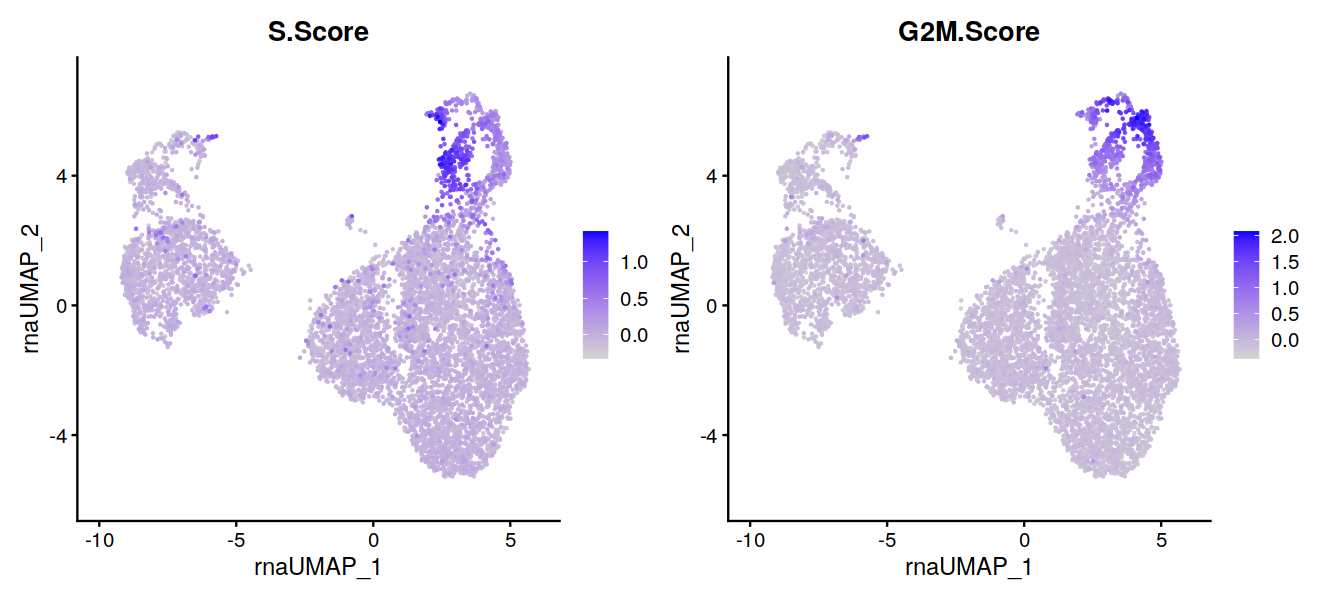

In [92]:
options(repr.plot.width=11, repr.plot.height=5)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("S.Score", "G2M.Score"), 
    min.cutoff = NA, 
    max.cutoff = NA, 
    ncol = 2, 
    order=T
)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 28 features requested have not been scaled (running reduction without them): MCM5, MCM2, UNG, MCM6, CDCA7, PRIM1, MLF1IP, RFC2, RPA2, SLBP, UBR7, MSH2, RAD51, CDC45, EXO1, TIPIN, DSCC1, CASP8AP2, CHAF1B, FAM64A, HN1, RANGAP1, NCAPD2, PSRC1, CKAP5, CTCF, G2E3, CBX5"
PC_ 1 
Positive:  CENPF, MKI67, TOP2A, HMGB2, TPX2, DLGAP5, NUSAP1, HMMR, ANLN, GTSE1 
	   CKS2, CENPE, CDK1, UBE2C, BIRC5, KIF20B, RRM2, CDC20, SMC4, HJURP 
	   TUBB4B, AURKA, NUF2, TACC3, KIF2C, KIF11, CCNB2, KIF23, CLSPN, NDC80 
Negative:  POLD3, POLA1, CCNE2, GAS2L3, CDC6, WDR76, LBR, UHRF1, FEN1, PCNA 
	   DTL, BLM, USP1, GMNN, MCM4, GINS2, E2F8, CENPA, BRIP1, ANP32E 
	   CDC25C, RRM1, HELLS, ECT2, NASP, RAD51AP1, ATAD2, CKAP2, AURKB, CDCA3 
PC_ 2 
Positive:  CLSPN, ATAD2, HELLS, DTL, BRIP1, RRM2, WDR76, CDC6, NASP, CCNE2 
	   UHRF1, MCM4, GINS2, PCNA, POLA1, TYMS, FEN1, GMNN, E2F8, BLM 
	   USP1, RAD51AP1, POLD3, RRM1, TM

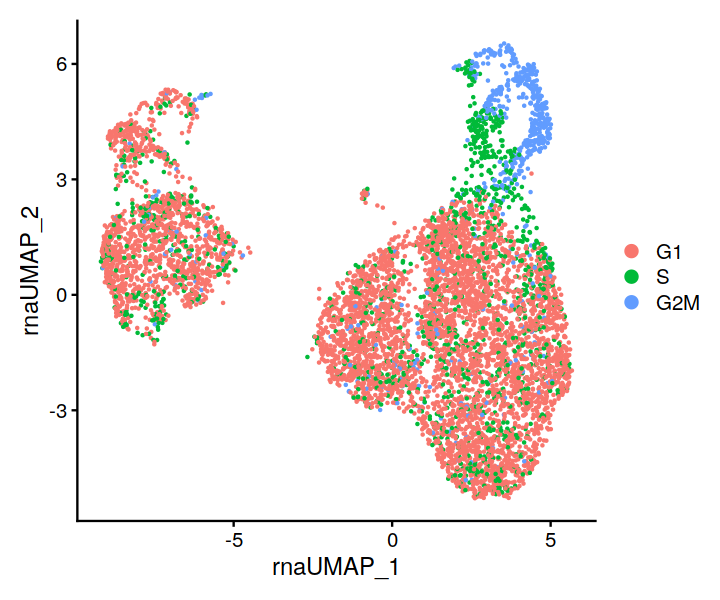

In [93]:
DefaultAssay(seurat) <- "SCT"
seurat_new <- RunPCA(seurat, npcs = 20, features = c(s.genes, g2m.genes))
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(seurat)

# Regress out %mito, #UMIs, S Score

In [94]:
seurat_new <- SCTransform(
  seurat_new,
  assay = 'RNA',
  new.assay.name = 'SCT',
  vars.to.regress = c('percent.mt', 'nFeature_RNA', 'nCount_RNA', 'S.Score', 'G2M.Score'),
  verbose = FALSE,
) %>% RunPCA() %>% RunUMAP(
        dims = 1:40,
        reduction.name = 'umap.rna',
        reduction.key = 'rnaUMAP_',
        verbose=FALSE
      )

PC_ 1 
Positive:  APOE, FTL, FN1, CRYAB, CDH6, MT1X, SOD2, S100A1, PLIN2, G0S2 
	   SERPINE1, VCAM1, FGB, VGF, SERPINA1, CTSB, MT1E, RHEX, RARRES2, TFPI2 
	   NRXN3, MGST1, SLC2A9, GPC6, LINC01705, GPX3, ABLIM3, AKR1C3, RRAD, MSC-AS1 
Negative:  ERBB4, KCNIP4, MECOM, WFDC2, MAL, FAM155A, AC019197.1, BST2, PDE1A, SFRP1 
	   S100A2, KITLG, KRT19, SKAP1, TFCP2L1, CSGALNACT1, SNED1, MUC1, PKHD1, TFAP2B 
	   ACSL4, DENND2A, GPNMB, PANTR1, KRT7, HOXB3, ARHGEF38, SGIP1, LRP1B, SIM1 
PC_ 2 
Positive:  dCas9, FKBP5, SERPINA1, KCNIP4, APOE, MALAT1, FTL, MT1X, ZIM3, NEAT1 
	   MDM2, SOD2, ADAMTS9-AS2, PKP4, FTH1, LINC01320, GBE1, ZNF385B, ERBB4, LINC01515 
	   CPD, PLIN2, PDE4D, MECOM, PDE1A, SERPINA3, RRAD, FNIP2, MSC-AS1, ACSM2A 
Negative:  KRT19, PLCB4, PLAU, DCBLD2, AKAP12, TUBA1A, CASC19, CCND1, AL355916.1, ARHGAP29 
	   TMSB10, ADIRF, KRT18, LGALS1, CDH6, FRMD5, THBS1, TUBA1B, C12orf75, ACTB 
	   TPM1, S100A6, ARL4C, ANXA2, HMGA2, CCN1, AHNAK, NALCN-AS1, AC078923.1, SCEL 
PC_ 3 
Positive:  

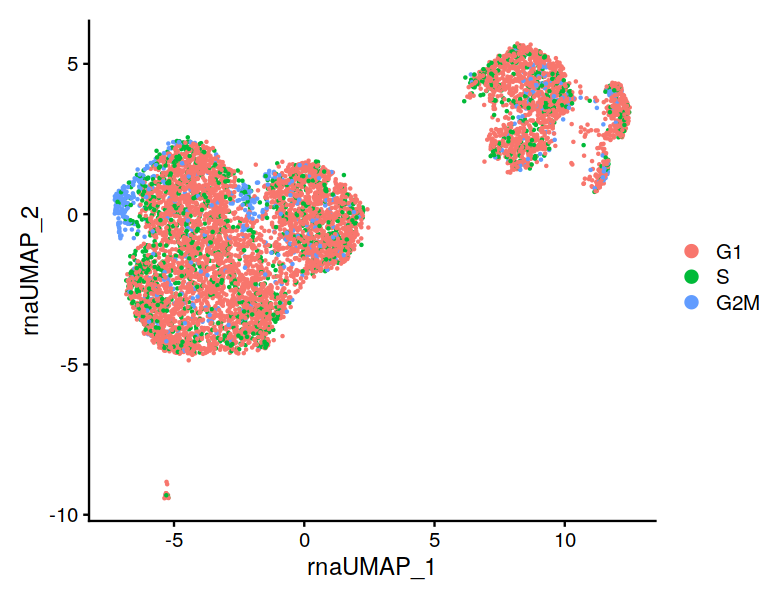

In [95]:
options(repr.plot.width=6.5, repr.plot.height=5)
DimPlot(seurat_new)

## Debug

In [96]:
donor_id = 1
select_donor = (df_soup$assignment == donor_id) & (df_soup$status == 'singlet')
donor_cells = df_soup[select_donor,]$barcode

In [97]:
length(donor_cells)

[1] 2819

In [98]:
head(df_soup)

barcode            status  assignment log_prob_singleton
AAACCCAAGAGCAGCT-1 AAACCCAAGAGCAGCT-1 singlet 3           -695             
AAACCCAAGCCGGAAT-1 AAACCCAAGCCGGAAT-1 doublet 1/2        -6694             
AAACCCAAGCTTAAGA-1 AAACCCAAGCTTAAGA-1 singlet 0          -1141             
AAACCCAAGGCTGTAG-1 AAACCCAAGGCTGTAG-1 singlet 0          -1577             
AAACCCAAGGTTTACC-1 AAACCCAAGGTTTACC-1 singlet 2          -1469             
AAACCCAAGTGATCGG-1 AAACCCAAGTGATCGG-1 singlet 2           -677             
                   log_prob_doublet cluster0 cluster1 cluster2 cluster3
AAACCCAAGAGCAGCT-1  -837            -2104    -2279    -2433      -695  
AAACCCAAGCCGGAAT-1 -4669            -8876    -6694    -6876    -11522  
AAACCCAAGCTTAAGA-1 -1789            -1141    -3152    -2890     -3469  
AAACCCAAGGCTGTAG-1 -2450            -1577    -4912    -3989     -5245  
AAACCCAAGGTTTACC-1 -1764            -3908    -4682    -1469     -5438  
AAACCCAAGTGATCGG-1  -795            -1757    -2186     -677     -2490

# Visualize RNA count distribution

In [99]:
DefaultAssay(seurat) <- "SCT"
top_genes <- sample(VariableFeatures(seurat), 80)
DefaultAssay(seurat) <- "RNA"
df_rna_counts <- as.data.frame(t(seurat[['RNA']]@counts[top_genes, ]))
rownames(df_rna_counts) <- NULL
df_rna_counts$n_rna <- rowSums(df_rna_counts)

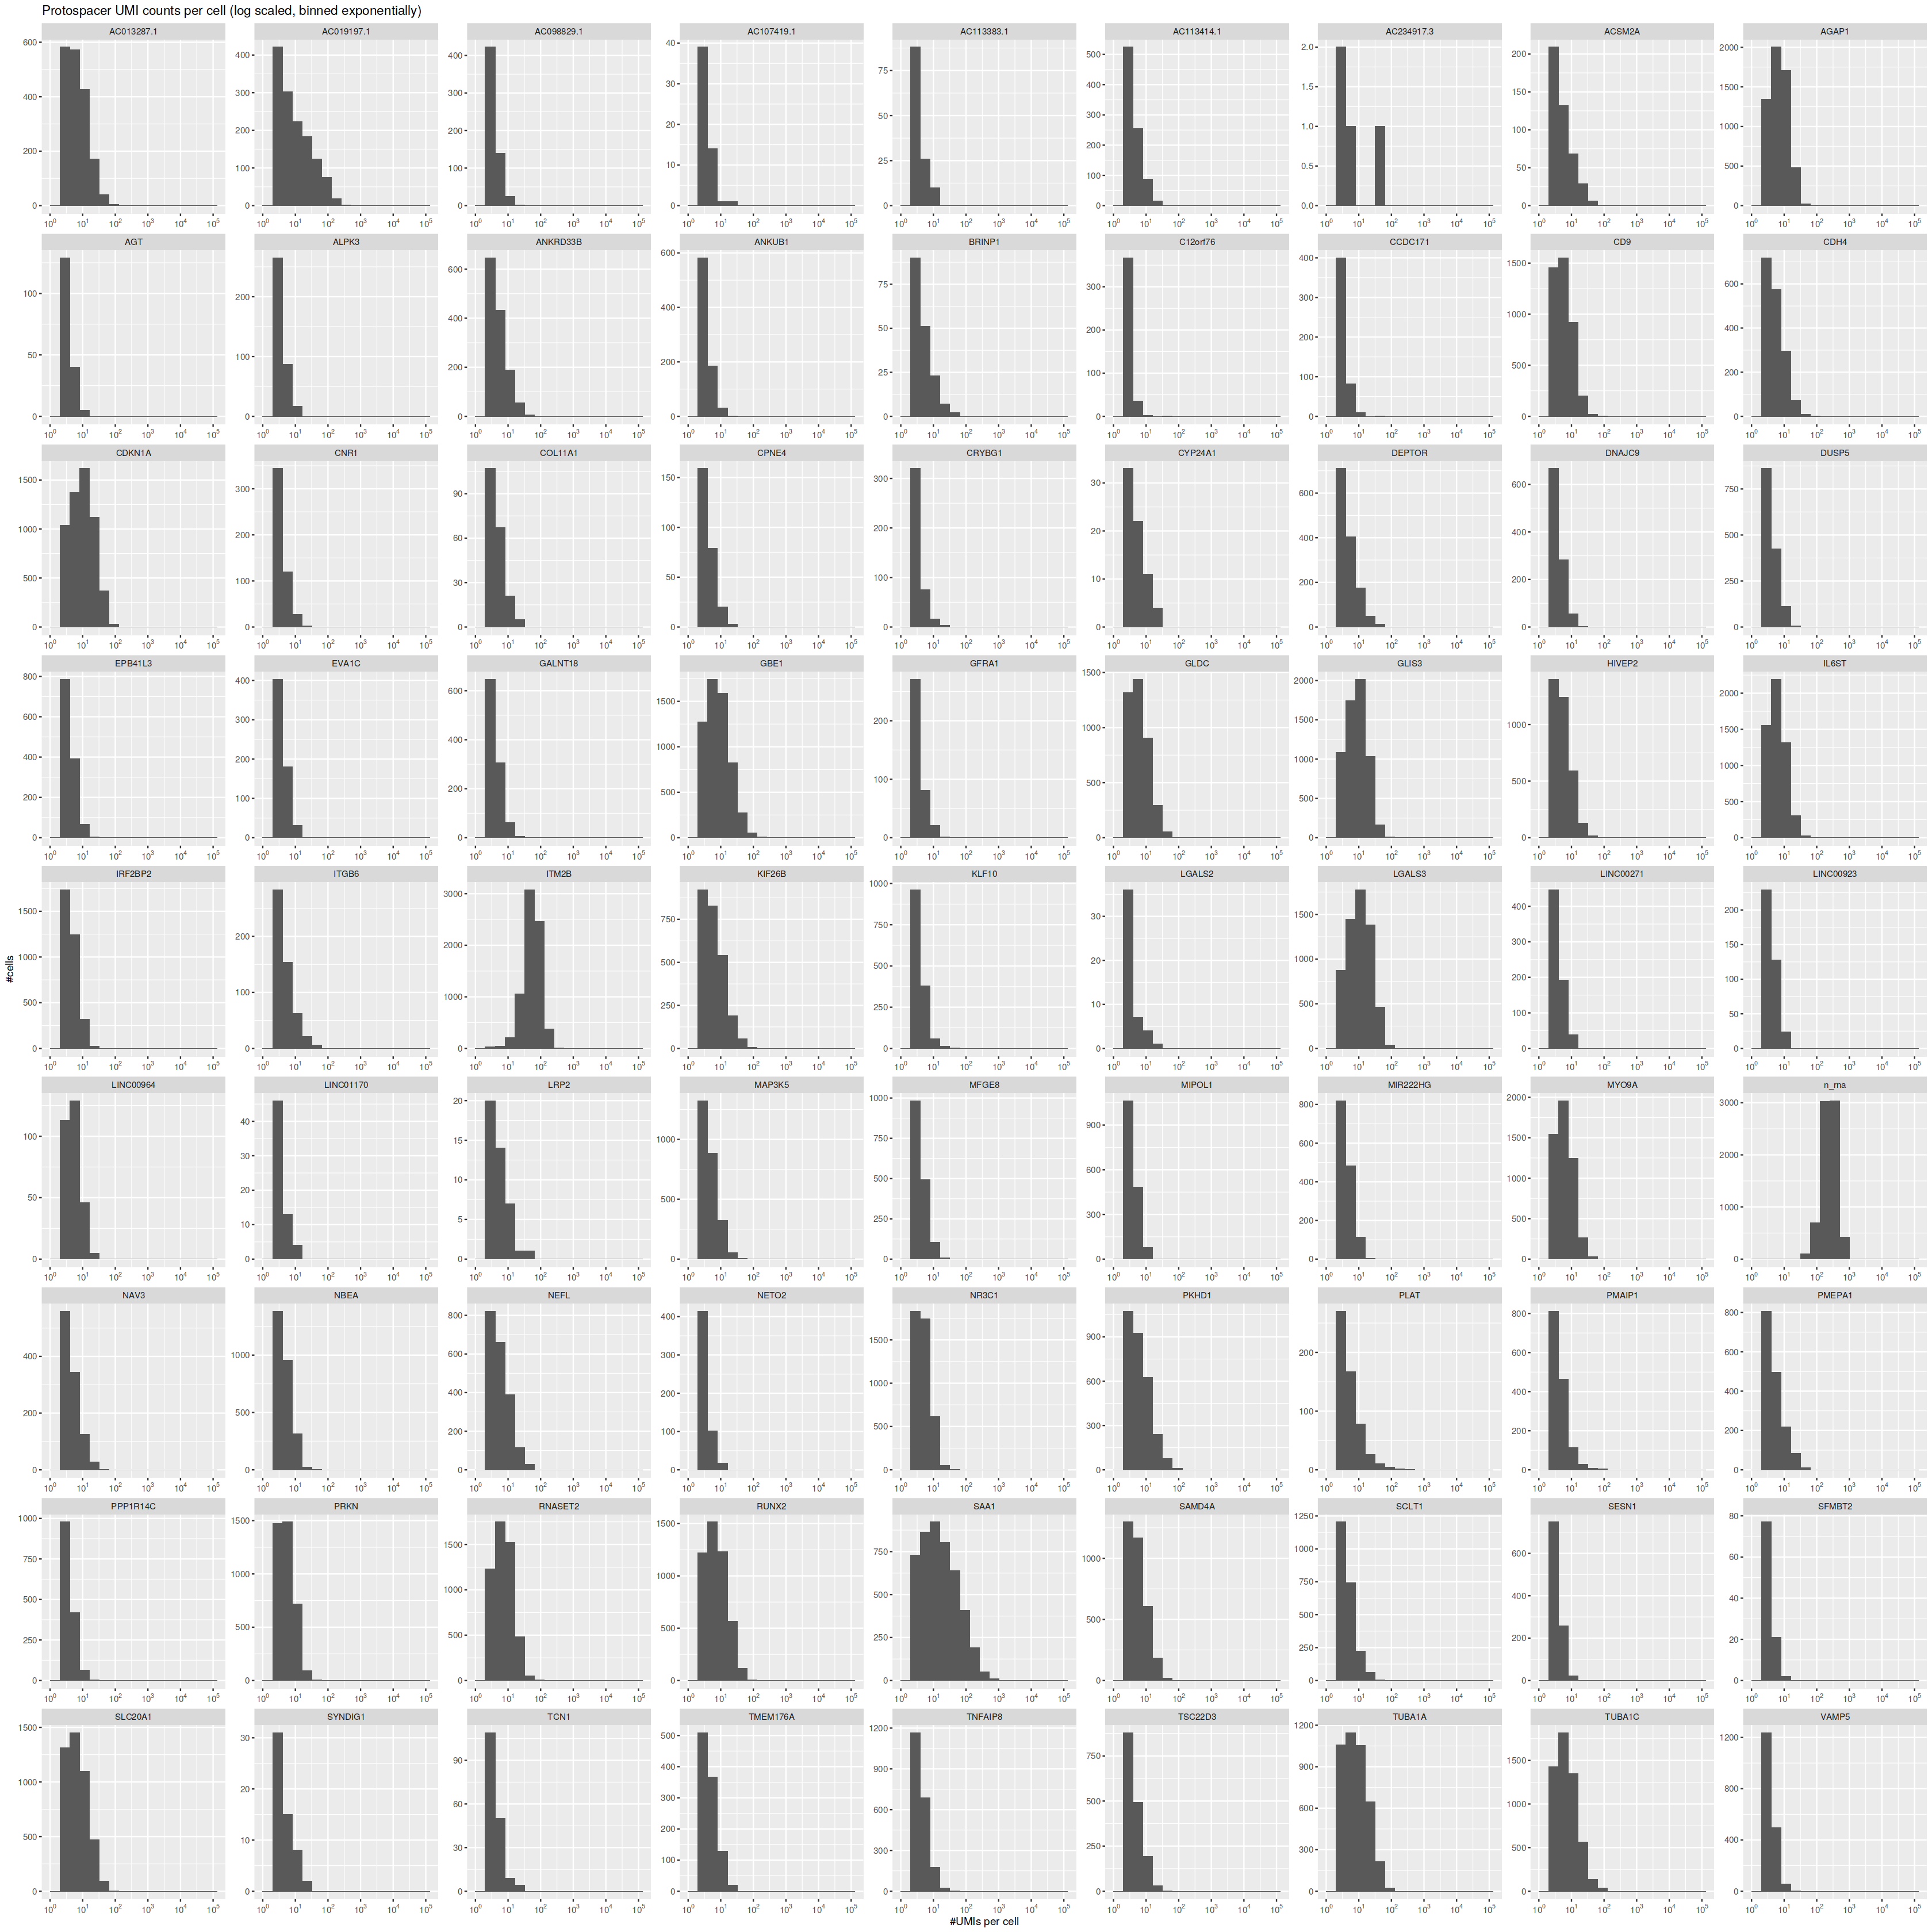

In [100]:
options(repr.plot.width=28, repr.plot.height=20)

data_long <- df_rna_counts %>%                    
  pivot_longer(colnames(df_rna_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)


options(repr.plot.width=28, repr.plot.height=28)
ggp1
#ggp2

# Number of guides vs dCas9 expression

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous x-axis"


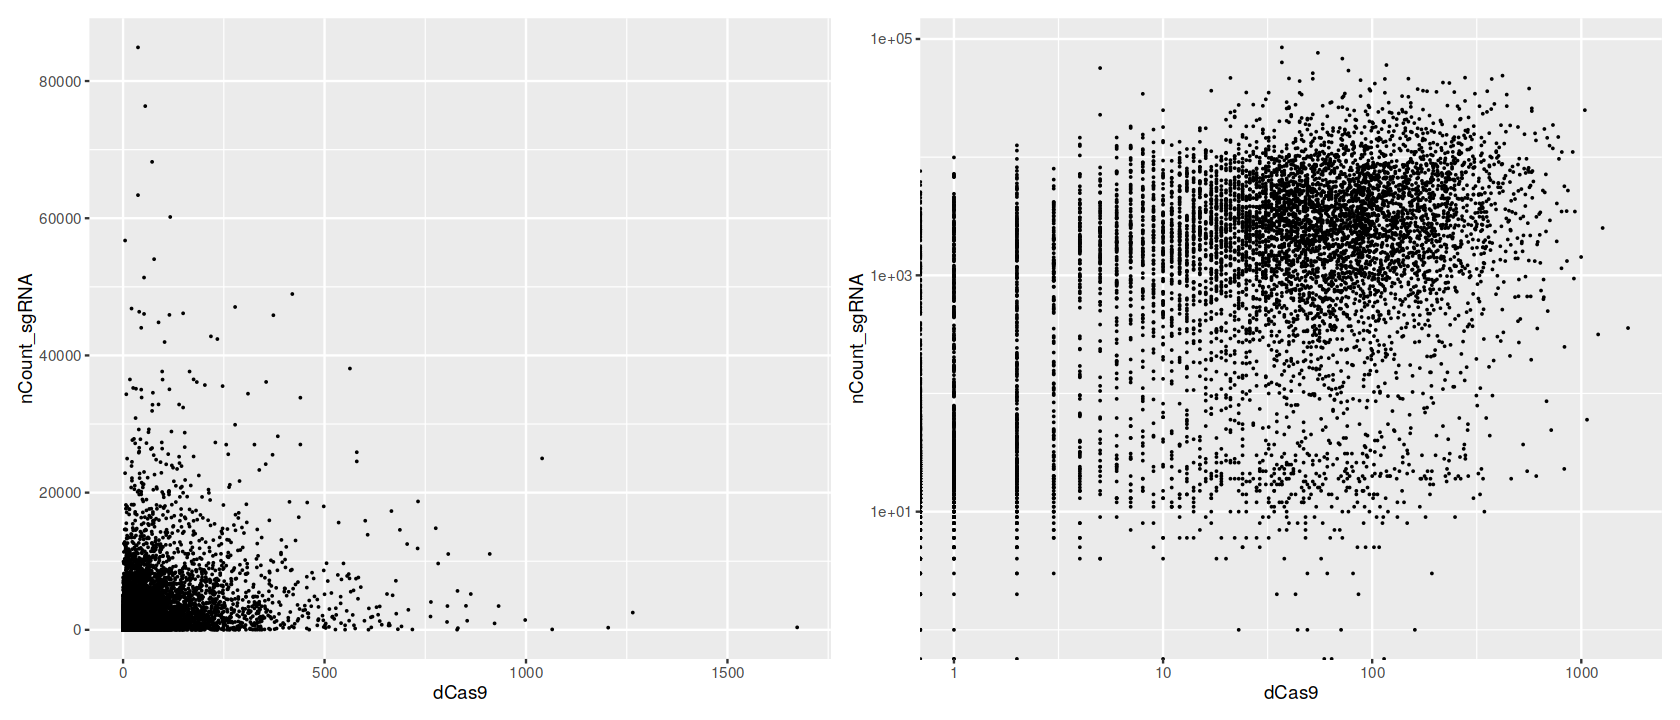

In [142]:
options(repr.plot.width=14, repr.plot.height=6)

ggplot(seurat@meta.data, aes(x=dCas9, nCount_sgRNA)) +
    geom_point(size=0.01) +

ggplot(seurat@meta.data, aes(x=dCas9, nCount_sgRNA)) +
    geom_point(size=0.01) +
    scale_y_log10() +
    scale_x_log10() 

In [143]:
cor(seurat$nCount_sgRNA, seurat$dCas9, method='pearson')
cor(seurat$nCount_sgRNA, seurat$dCas9, method='spearman')

[1] 0.21

[1] 0.47